# Figure making
This notebook is for loading results from experiments, making pretty figures and saving them in svg format.

#### Imports and data loading

In [1]:
import sys
sys.path.append('../')

import os
import json
import pandas as pd
import numpy as np
import torch
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

from utils.files import project_root
from utils.configs import *
from utils.plotting import *
from utils.statsalg import *
from utils.annotations import load_annotations, load_receptor_maps
from utils.helpers import sort_features, get_groups

from load_models_data import load_dataset, load_vgaes, load_mlps
from preprocessing.metrics import get_rsn_mapping
from experiments.ingredients.data_ingredient import get_conditions
from experiments.ingredients.vgae_ingredient import get_test_reconstructions, evaluate_fc_reconstructions, evaluate_x_reconstructions

Loading BokehJS ...

In [2]:
# Define model name and directory with weights and configs
output_dir = os.path.join(project_root(), 'outputs')
weights_dir = os.path.join(project_root(), 'outputs', 'graphtrip', 'weights')
config = load_ingredient_configs(weights_dir, ingredients=['dataset', 'vgae_model', 'mlp_model'])
weight_filenames = get_weight_filenames_from_config(config)
test_indices = np.loadtxt(os.path.join(weights_dir, weight_filenames['test_fold_indices'][0]), dtype=int)

Loading model configurations.


In [3]:
# Load dataset, VGAEs and MLPs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = load_dataset(config['dataset'])
vgaes = load_vgaes(config['vgae_model'], weights_dir, weight_filenames['vgae'])
mlps = load_mlps(config['mlp_model'], vgaes[0].readout_dim, weights_dir, weight_filenames['mlp'])

# Some info for plotting
conditions = np.array(get_conditions(data, config['dataset']['graph_attrs']))
rsn_mapping, rsn_names = get_rsn_mapping(data.atlas)
num_folds = len(vgaes)
num_subs = len(data)
num_nodes = len(rsn_mapping)
x_cmaps = [CMAP_5HT1A, CMAP_5HT2A, CMAP_5HTT]

rsn_indices = np.argsort(rsn_mapping)
rsn_ticks, rsn_tick_labels = get_rsn_ticks(rsn_mapping, rsn_names)
node_attrs = config['dataset']['node_attrs']
node_attrs = [attr.split('_')[0] for attr in node_attrs] # use short names

#### Define figure directory

In [4]:
# Define output directory for saving figures
figure_dir = os.path.join(project_root(), 'notebooks', 'figures')
os.makedirs(figure_dir, exist_ok=True)

# Output directory for saving regional values that need to be plotted on a brain surface (with MATLAB BrainNetViewer)
brain_surface_dir = os.path.join(figure_dir, 'brain_plots')
os.makedirs(brain_surface_dir, exist_ok=True)

# Save figures
save_figs = True

## Dataset stats

In [5]:
# Load psilodep2 annotations
df = load_annotations("psilodep2", filter={'Exclusion': 0})

# Count number of females in experimental condition
n_females_exp = len(df[(df['Condition']=='E') & (df['Gender']=='F')])
print(f"Number of females in escitalopram condition: {n_females_exp}")

n_females_exp = len(df[(df['Condition']=='P') & (df['Gender']=='F')])
print(f"Number of females in psilocybin condition: {n_females_exp}")

Number of females in escitalopram condition: 6
Number of females in psilocybin condition: 8


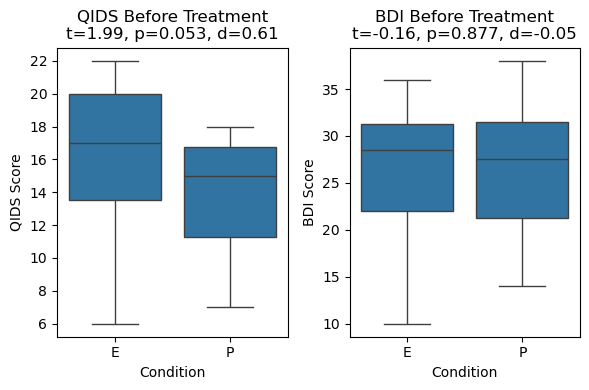

In [6]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plot QIDS boxplot
sns.boxplot(data=df, x='Condition', y='QIDS_Before', ax=ax1)
ax1.set_xlabel('Condition')
ax1.set_ylabel('QIDS Score')

# QIDS t-test
qids_e = df[df['Condition']=='E']['QIDS_Before']
qids_p = df[df['Condition']=='P']['QIDS_Before']
t_qids, p_qids = stats.ttest_ind(qids_e, qids_p)
d_qids = (qids_e.mean() - qids_p.mean()) / np.sqrt((qids_e.var() + qids_p.var()) / 2)

ax1.set_title(f'QIDS Before Treatment\nt={t_qids:.2f}, p={p_qids:.3f}, d={d_qids:.2f}')

# Plot BDI boxplot  
sns.boxplot(data=df, x='Condition', y='BDI_Before', ax=ax2)
ax2.set_xlabel('Condition')
ax2.set_ylabel('BDI Score')

# BDI t-test
bdi_e = df[df['Condition']=='E']['BDI_Before']
bdi_p = df[df['Condition']=='P']['BDI_Before']
t_bdi, p_bdi = stats.ttest_ind(bdi_e, bdi_p)
d_bdi = (bdi_e.mean() - bdi_p.mean()) / np.sqrt((bdi_e.var() + bdi_p.var()) / 2)

ax2.set_title(f'BDI Before Treatment\nt={t_bdi:.2f}, p={p_bdi:.3f}, d={d_bdi:.2f}')

plt.tight_layout()

if save_figs:
    plt.savefig(os.path.join(output_dir, 'depression_scores.svg'))
 

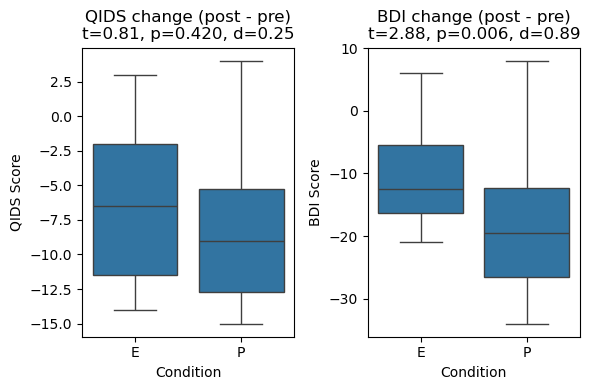

In [7]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plot QIDS boxplot
sns.boxplot(data=df, x='Condition', y='Delta_QIDS', ax=ax1)
ax1.set_xlabel('Condition')
ax1.set_ylabel('QIDS Score')

# QIDS t-test
qids_e = df[df['Condition']=='E']['Delta_QIDS']
qids_p = df[df['Condition']=='P']['Delta_QIDS']
t_qids, p_qids = stats.ttest_ind(qids_e, qids_p)
d_qids = (qids_e.mean() - qids_p.mean()) / np.sqrt((qids_e.var() + qids_p.var()) / 2)

ax1.set_title(f'QIDS change (post - pre)\nt={t_qids:.2f}, p={p_qids:.3f}, d={d_qids:.2f}')

# Plot BDI boxplot  
sns.boxplot(data=df, x='Condition', y='Delta_BDI', ax=ax2)
ax2.set_xlabel('Condition')
ax2.set_ylabel('BDI Score')

# BDI t-test
bdi_e = df[df['Condition']=='E']['Delta_BDI']
bdi_p = df[df['Condition']=='P']['Delta_BDI']
t_bdi, p_bdi = stats.ttest_ind(bdi_e, bdi_p)
d_bdi = (bdi_e.mean() - bdi_p.mean()) / np.sqrt((bdi_e.var() + bdi_p.var()) / 2)

ax2.set_title(f'BDI change (post - pre)\nt={t_bdi:.2f}, p={p_bdi:.3f}, d={d_bdi:.2f}')

plt.tight_layout()
 

In [8]:
# Create contingency table of Stop_SSRI vs Condition
contingency = pd.crosstab(df['Condition'], df['Stop_SSRI'])
print("Contingency table of Stop_SSRI vs Condition:")
print(contingency)
print()

# Perform chi-square test
chi2, p_value = stats.chi2_contingency(contingency)[:2]

# Print results
print(f"Chi-square test results:")
print(f"chi2 = {chi2:.3f}")
print(f"p-value = {p_value:.3f}")

Contingency table of Stop_SSRI vs Condition:
Stop_SSRI   0   1
Condition        
E          13   7
P          12  10

Chi-square test results:
chi2 = 0.140
p-value = 0.708


---
# Main figures

## Fig. 2: Prediction performance of graphTRIP

In [9]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.2')
os.makedirs(fig_subdir, exist_ok=True)

#### a. graphTRIP and control MLP performance

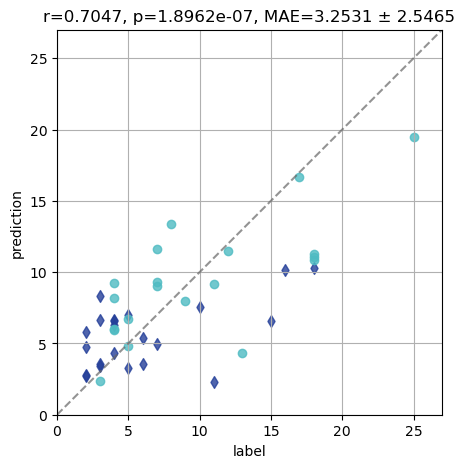

In [10]:
# Load prediction results
results = pd.read_csv(os.path.join(weights_dir, 'prediction_results.csv'))
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphTRIP_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

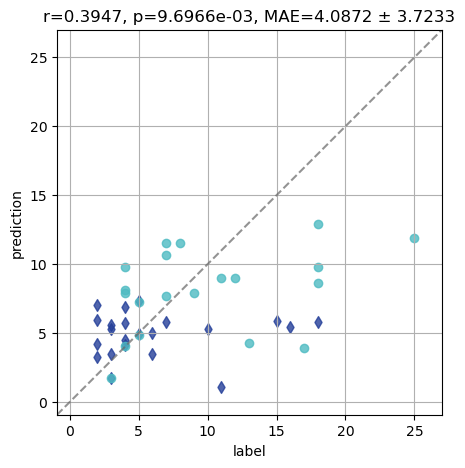

In [11]:
# Clinical data only performance
results_dir = os.path.join(output_dir, 'benchmarks', 'control_mlp')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))
save_path = None if not save_figs else os.path.join(fig_subdir, 'control_mlp_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

#### b. graphTRIP and control MLP partial correlations
Performance after controlling for treatment.

True group means:
   escitalopram: 9.95
   psilocybin: 6.136363636363637

MLP predicted group means:
   escitalopram: 9.450643754005432
   psilocybin: 5.5869084705006


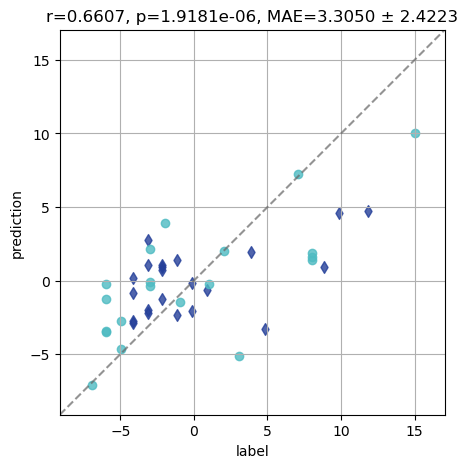

In [ ]:
# graphTRIP
results = pd.read_csv(os.path.join(weights_dir, 'prediction_results.csv'))

# Compute true mean QIDS for each drug condition
escitalopram_mean = results[results['Condition'] == -1.0]['label'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['label'].mean()
print("True group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
print()

# Subtract the true mean for each group
results.loc[results['Condition'] == -1.0, 'label'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'label'] -= psilocybin_mean

# Subtract the predicted group mean for MLP
escitalopram_mean = results[results['Condition'] == -1.0]['prediction'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['prediction'].mean()
print("MLP predicted group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
results.loc[results['Condition'] == -1.0, 'prediction'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'prediction'] -= psilocybin_mean

# Plot the true vs predicted scatter
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphtrip_partial_corr.svg')
true_vs_pred_scatter(results, save_path=save_path)

True group means:
   escitalopram: 9.95
   psilocybin: 6.136363636363637

MLP predicted group means:
   escitalopram: 8.127636909484863
   psilocybin: 4.911795258522034


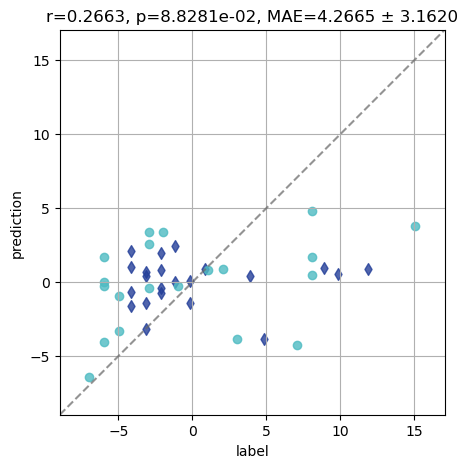

In [13]:
# Control MLP
results_dir = os.path.join(output_dir, 'benchmarks', 'control_mlp')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))

# Compute true mean QIDS for each drug condition
escitalopram_mean = results[results['Condition'] == -1.0]['label'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['label'].mean()
print("True group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
print()

# Subtract the true mean for each group
results.loc[results['Condition'] == -1.0, 'label'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'label'] -= psilocybin_mean

# Subtract the predicted group mean for MLP
escitalopram_mean = results[results['Condition'] == -1.0]['prediction'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['prediction'].mean()
print("MLP predicted group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
results.loc[results['Condition'] == -1.0, 'prediction'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'prediction'] -= psilocybin_mean

# Plot the true vs predicted scatter
save_path = None if not save_figs else os.path.join(fig_subdir, 'control_mlp_partial_corr.svg')
true_vs_pred_scatter(results, save_path=save_path)

#### c-d. VGAE reconstruction performance

In [14]:
# Get test reconstructions
test_indices_list = [np.where(test_indices == fold)[0] for fold in range(num_folds)]
adj_orig_rcn, x_orig_rcn, fold_assignments = get_test_reconstructions(vgaes, data, test_indices_list, mean_std=None)

# Example subject
sub = 0

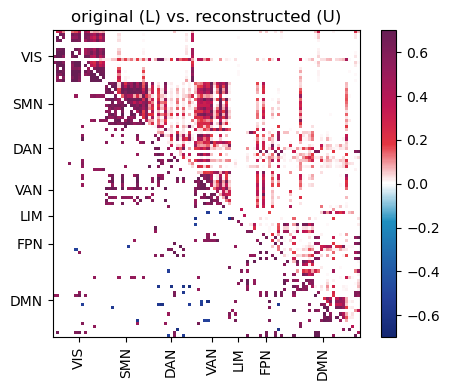

In [15]:
# Plot FC reconstructions
vrange = (-0.7, 0.7)
cmap = COOLWARM
save_path = None if not save_figs else os.path.join(fig_subdir, f'fc_reconstruction_sub{sub}.svg')
plot_fc_reconstruction_single(adj_orig_rcn, 
                            rsn_mapping=rsn_mapping, 
                            rsn_labels=rsn_names, 
                            subject_idx=sub,
                            cmap=cmap, 
                            vrange=vrange,
                            save_path=save_path)

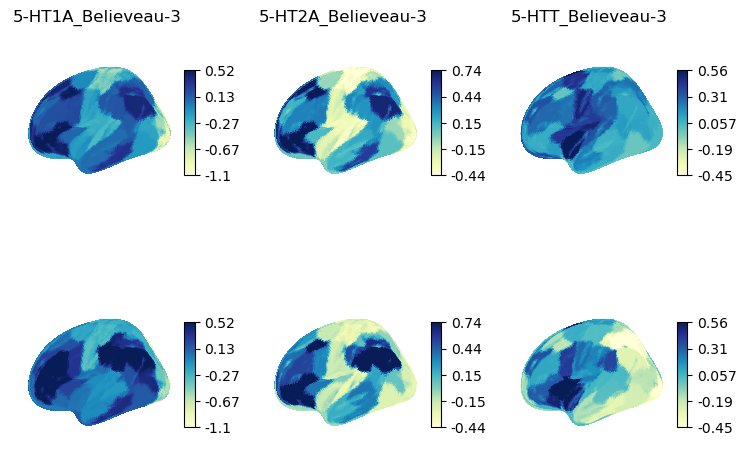

In [16]:
save_path = None if not save_figs else os.path.join(fig_subdir, f'x_reconstructions_sub{sub}.png')
reconstructed = x_orig_rcn['reconstructed'][:, :, sub]
original = x_orig_rcn['original'][:, :, sub]
data2plot = np.stack([reconstructed, original], axis=0)
plot_brain_surface_grid(data2plot, 
                        atlas=data.atlas, 
                        view='medial',
                        cmap=x_cmaps,
                        column_names=x_orig_rcn['feature_names'],
                        save_path=save_path);

# Save regional values in brain_surface dir
if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, 'graphTRIP_reconstructions')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    reconstructed_df = pd.DataFrame(reconstructed, columns=x_orig_rcn['feature_names'])
    original_df = pd.DataFrame(original, columns=x_orig_rcn['feature_names'])
    reconstructed_df.to_csv(os.path.join(brain_surface_dir, f'reconstructed_sub{sub}.csv'), index=False)
    original_df.to_csv(os.path.join(brain_surface_dir, f'original_sub{sub}.csv'), index=False)

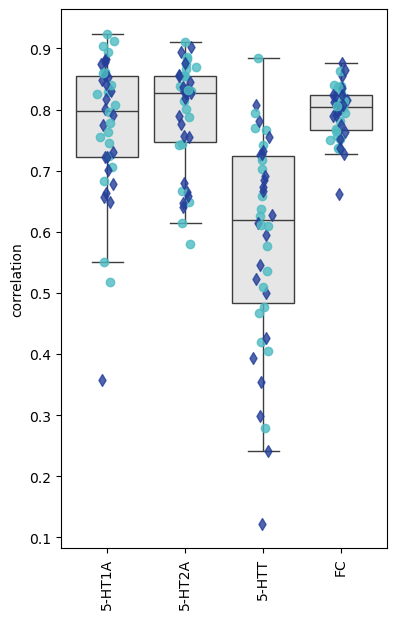

In [17]:
# Plot FC and x original-vs-reconstructed correlations together
# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(adj_orig_rcn)
x_orig_rcn['metrics'] = evaluate_x_reconstructions(x_orig_rcn)

# Add FC correlations to x metrics (to plot together)
x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, 'original_vs_reconstructed_corrs.svg')
plot_metric_boxplot(x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

#### e. Permutation importance

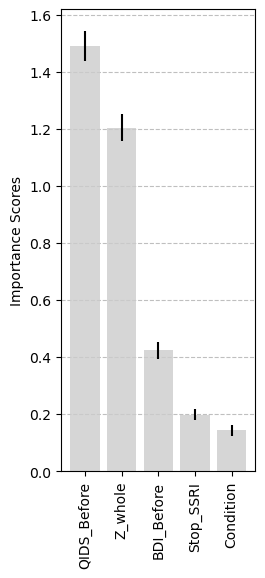

In [18]:
# Permutation Importance
results_dir = os.path.join(output_dir, 'graphtrip', 'permutation_importance')
results = pd.read_csv(os.path.join(results_dir, 'importance_scores_aggregated.csv'))

# Sort the rows of results by mean importance score
results = results.sort_values(by='mean', ascending=False)
save_path = None if not save_figs else os.path.join(fig_subdir, 'importance_scores_aggregated.svg')
permutation_importance_bar_chart(results, yerr_column='se', color=NEUTRAL, alpha=0.8, save_path=save_path)

## Fig. 3: Generalisation across brain atlases

In [19]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.3')
os.makedirs(fig_subdir, exist_ok=True)

#### a. Transfer to Schaefer 200

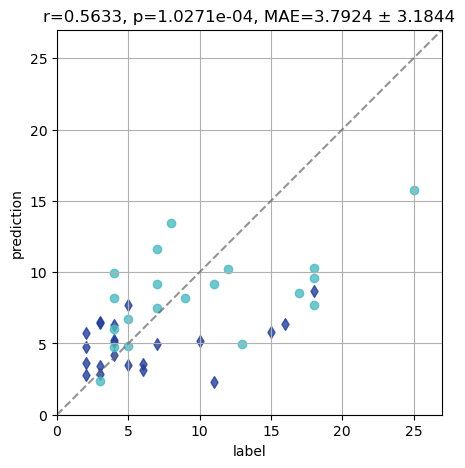

In [20]:
# Schaefer 200
atlas = 'schaefer200'
results_dir = os.path.join(output_dir, 'graphtrip', 'transfer_atlas', atlas)
results = pd.read_csv(os.path.join(results_dir, 'initial_prediction_results.csv'))
save_path = None if not save_figs else os.path.join(fig_subdir, f'true_vs_pred_{atlas}.svg')
true_vs_pred_scatter(results, save_path=save_path)

In [21]:
# Load Schaefer 200 data
atlas_config = load_ingredient_configs(results_dir, ingredients=['dataset'])
atlas_data = load_dataset(atlas_config['dataset'])

# Get new rsn_mapping for Schaefer 200
atlas_rsn_mapping, atlas_rsn_labels = get_rsn_mapping(atlas_data.atlas)

# Get reconstructions from the new data, using the same VGAEs as the original model
test_indices_list = [np.where(test_indices == fold)[0] for fold in range(num_folds)]
adj_orig_rcn, x_orig_rcn, fold_assignments = get_test_reconstructions(vgaes, atlas_data, test_indices_list, mean_std=None)

# Example subject
sub = 0

Loading model configurations.


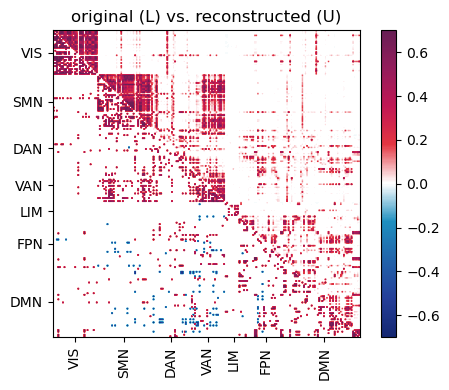

In [22]:
# Plot FC reconstructions
vrange = (-0.7, 0.7)
cmap = COOLWARM
save_path = None if not save_figs else os.path.join(fig_subdir, f'fc_reconstruction_sub{sub}_{atlas}.svg')
plot_fc_reconstruction_single(adj_orig_rcn, 
                            rsn_mapping=atlas_rsn_mapping, 
                            rsn_labels=atlas_rsn_labels, 
                            subject_idx=sub,
                            cmap=cmap, 
                            vrange=vrange,
                            save_path=save_path)

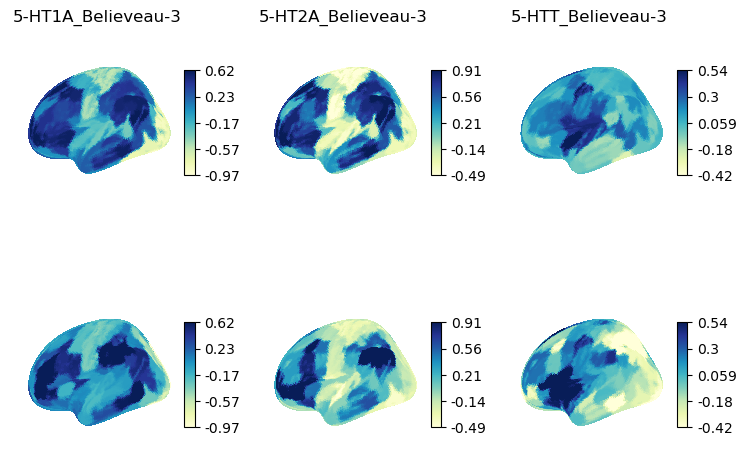

In [23]:
save_path = None if not save_figs else os.path.join(fig_subdir, f'x_reconstructions_sub{sub}_{atlas}.png')
original = x_orig_rcn['original'][:, :, sub]
reconstructed = x_orig_rcn['reconstructed'][:, :, sub]
data2plot = np.stack([reconstructed, original], axis=0)
plot_brain_surface_grid(data2plot, 
                        atlas=atlas_data.atlas, 
                        view='medial',
                        cmap=x_cmaps,
                        column_names=x_orig_rcn['feature_names'],
                        save_path=save_path);

if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, f'{atlas}_reconstructions')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    reconstructed_df = pd.DataFrame(reconstructed, columns=x_orig_rcn['feature_names'])
    original_df = pd.DataFrame(original, columns=x_orig_rcn['feature_names'])
    reconstructed_df.to_csv(os.path.join(brain_surface_dir, f'reconstructed_sub{sub}_{atlas}.csv'), index=False)
    original_df.to_csv(os.path.join(brain_surface_dir, f'original_sub{sub}_{atlas}.csv'), index=False)

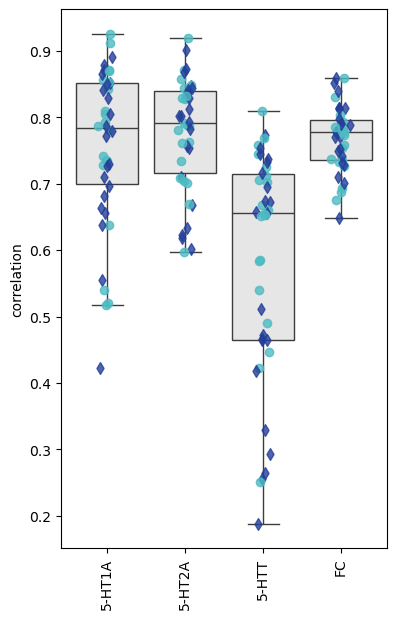

In [24]:
# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(adj_orig_rcn)
x_orig_rcn['metrics'] = evaluate_x_reconstructions(x_orig_rcn)

# Add FC correlations to x metrics (to plot together)
x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, f'original_vs_reconstructed_corrs_{atlas}.svg')
plot_metric_boxplot(x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

#### c-d. Hybrid model performance and permutation importance

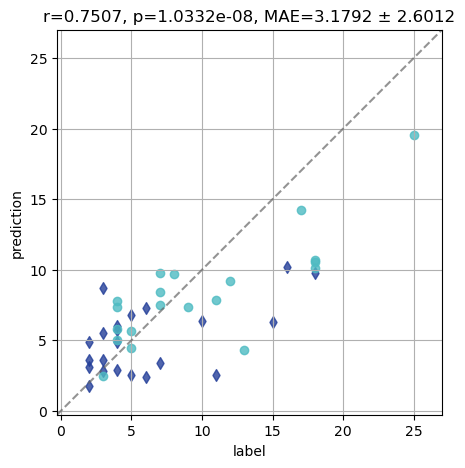

In [25]:
results_dir = os.path.join(output_dir, 'hybrid', 'weights')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))
save_path = None if not save_figs else os.path.join(fig_subdir, 'hybrid_true_vs_pred_scatter.svg')
true_vs_pred_scatter(results, save_path=save_path)

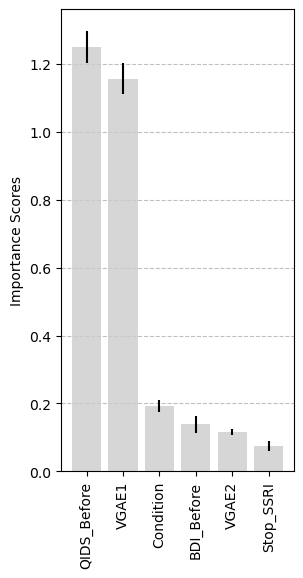

In [26]:
# Permutation Importance with hybrid model
results_dir = os.path.join(output_dir, 'hybrid', 'permutation_importance')
results = pd.read_csv(os.path.join(results_dir, 'permutation_importance.csv'))

# Sort the rows of results by mean importance score
results = results.sort_values(by='importance_mean', ascending=False)
save_path = None if not save_figs else os.path.join(fig_subdir, 'hybrid_permutation_importance.svg')
permutation_importance_bar_chart(results, color=NEUTRAL, alpha=0.8, save_path=save_path,
                                 y_column='importance_mean', yerr_column='importance_se', feature_column='feature')

## Fig. 4: Generalisation to an independent dataset

In [27]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.4')
os.makedirs(fig_subdir, exist_ok=True)

#### b. Reconstruction performance of pretrained model (without finetuning)

In [28]:
# Load psildeop1 dataset
psilodep1_config = load_ingredient_configs(results_dir, ingredients=['dataset', 'vgae_model'])
psilodep1_data = load_dataset(psilodep1_config['dataset'])
num_psilodep1_subs = len(psilodep1_data)
psilodep1_conditions = np.ones(num_psilodep1_subs)
num_nodes, num_node_attrs = psilodep1_data[0].x.shape
psilodep1_num_subs = len(psilodep1_data)

Loading model configurations.


In [29]:
# Initialize arrays for original and reconstructed FCs and x features
adj_orig_rcn = {'original': np.zeros((num_nodes, num_nodes, psilodep1_num_subs)),
                'reconstructed': np.zeros((num_nodes, num_nodes, psilodep1_num_subs))}
x_orig_rcn = {'original': np.zeros((num_nodes, num_node_attrs, psilodep1_num_subs)),
              'reconstructed': np.zeros((num_nodes, num_node_attrs, psilodep1_num_subs))}

# For each pretrained model, get the reconstructions
for i in range(len(vgaes)):
    # All subjects are test subjects
    psilodep1_test_indices_list = [np.arange(num_psilodep1_subs)]

    # Get the reconstructions
    adj_orig_rcn, x_orig_rcn, fold_assignments = get_test_reconstructions([vgaes[i]], psilodep1_data, psilodep1_test_indices_list, mean_std=None)

    # Add the reconstructions to the arrays
    adj_orig_rcn['reconstructed'] += adj_orig_rcn['reconstructed']
    x_orig_rcn['reconstructed'] += x_orig_rcn['reconstructed']

    # Store the original arrays once
    if i == 0:
        adj_orig_rcn['original'] = adj_orig_rcn['original']
        x_orig_rcn['original'] = x_orig_rcn['original']

# Average the reconstructions
adj_orig_rcn['reconstructed'] /= len(vgaes)
x_orig_rcn['reconstructed'] /= len(vgaes)

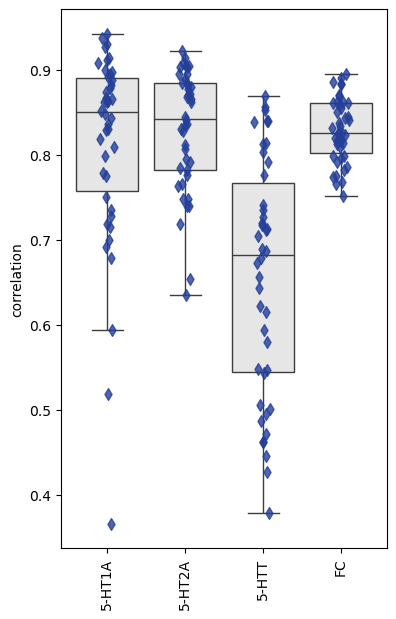

In [30]:
# Evaluate mean FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(adj_orig_rcn)
x_orig_rcn['metrics'] = evaluate_x_reconstructions(x_orig_rcn)

# Add FC correlations to x metrics (to plot together)
x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, 'original_vs_reconstructed_corrs.svg')
plot_metric_boxplot(x_orig_rcn['metrics']['corr'], 
                    conditions=psilodep1_conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

#### c. Prediction performance after finetuning

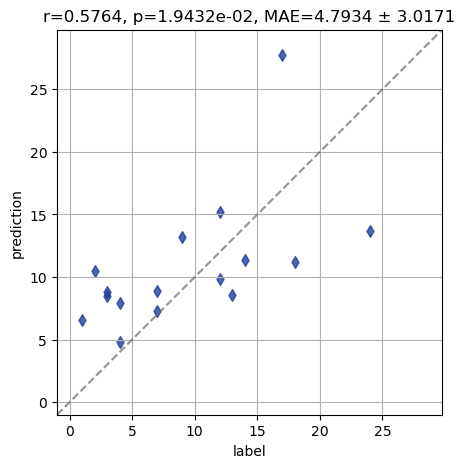

In [31]:
# Finetuned prediction results
results_dir = os.path.join(output_dir, 'psilodep1', 'finetuned_weights')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results_mean_vote.csv'))
results['Condition'] = 1 # add psilocybin condition for plotting
save_path = None if not save_figs else os.path.join(fig_subdir, 'finetuned_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

#### d. The effect of pretraining

In [32]:
# Get the distribution of performance for all finetuned models
finetuning_dir = os.path.join(output_dir, 'psilodep1', 'finetuned_weights')

# Load the performance of pre-trained models BEFORE finetuning
initial_metrics_file = os.path.join(finetuning_dir, 'initial_metrics_summary.csv')
initial_metrics_df = pd.read_csv(initial_metrics_file)

# Load the final metrics of pre-trained models AFTER finetuning
final_metrics = []
pretrained_model_dirs = [d for d in os.listdir(finetuning_dir) if d.startswith('pretrained_model')]
for i, pretrained_model_dir in enumerate(pretrained_model_dirs):
    finetuned_metrics_file = os.path.join(finetuning_dir, pretrained_model_dir, 'final_metrics.csv')
    df = pd.read_csv(finetuned_metrics_file)
    df['pretrained_model'] = i
    final_metrics.append(df)
finetuned_metrics_df= pd.concat(final_metrics, ignore_index=True)

In [33]:
# Get the distribution of performance for retrained models (no pre-training)
model_names = ['control_mlp', 'graphtrip']
retrained_metrics_dfs = {}

for model_name in model_names:
    retraining_dir = os.path.join(output_dir, 'psilodep1', 'wo_pretraining', model_name)
    retrained_metrics_file = os.path.join(retraining_dir, 'final_metrics_summary.csv')

    # If the file does not exist, aggregate the metrics from all seeds
    if not os.path.exists(retrained_metrics_file):
        seed_dirs = [d for d in os.listdir(retraining_dir) if d.startswith('seed_')]
        final_metrics = []
        for seed_dir in seed_dirs:
            metrics_file = os.path.join(retraining_dir, seed_dir, 'final_metrics.csv')
            if os.path.exists(metrics_file):
                seed_metrics = pd.read_csv(metrics_file)
                final_metrics.append(seed_metrics)
        
        # Save combined metrics
        retrained_metrics_dfs[model_name] = pd.concat(final_metrics, ignore_index=True)
        retrained_metrics_dfs[model_name].to_csv(retrained_metrics_file, index=False)

    else:
        retrained_metrics_dfs[model_name] = pd.read_csv(retrained_metrics_file)

Minimum significant r-value: 0.49730903545923993


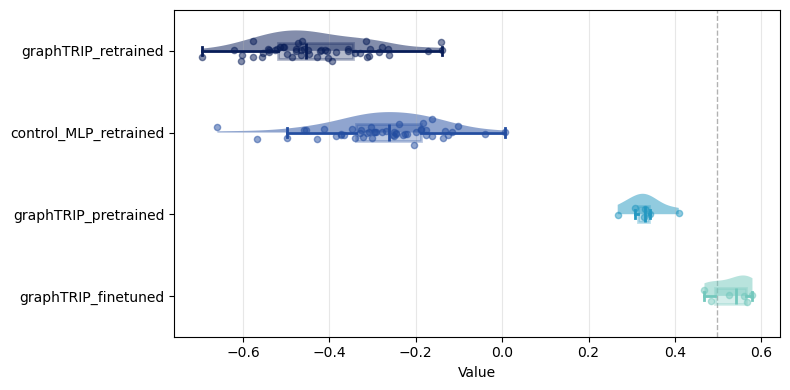

In [34]:
# Get the minimum significant r-value
n = 16 # number of subjects in the validation dataset
r_min = min_significant_r(n)
print(f'Minimum significant r-value: {r_min}')

# Plot performance distributions of pre-trained and retrained models
distributions = {'graphTRIP_finetuned': finetuned_metrics_df['r'].values,
                 'graphTRIP_pretrained': initial_metrics_df['r'].values,
                 'control_MLP_retrained': retrained_metrics_dfs['control_mlp']['r'].values,
                 'graphTRIP_retrained': retrained_metrics_dfs['graphtrip']['r'].values}
offset = 2
colors = plot_colormap_stack('YlGnBu', len(distributions)+offset, make_plot=False)
colors = colors[offset:]
palette = {name: color for name, color in zip(distributions.keys(), colors)}
save_path = None if not save_figs else os.path.join(fig_subdir, 'raincloud_retrained_vs_pretrained.svg')
plot_raincloud(distributions, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.5, 
               box_alpha=0.3,
               vline=r_min, 
               sort_by_mean=False, 
               figsize=(8, 4))

## Fig. 5: Interpretability

In [35]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.5')
os.makedirs(fig_subdir, exist_ok=True)

#### a. Attention weights

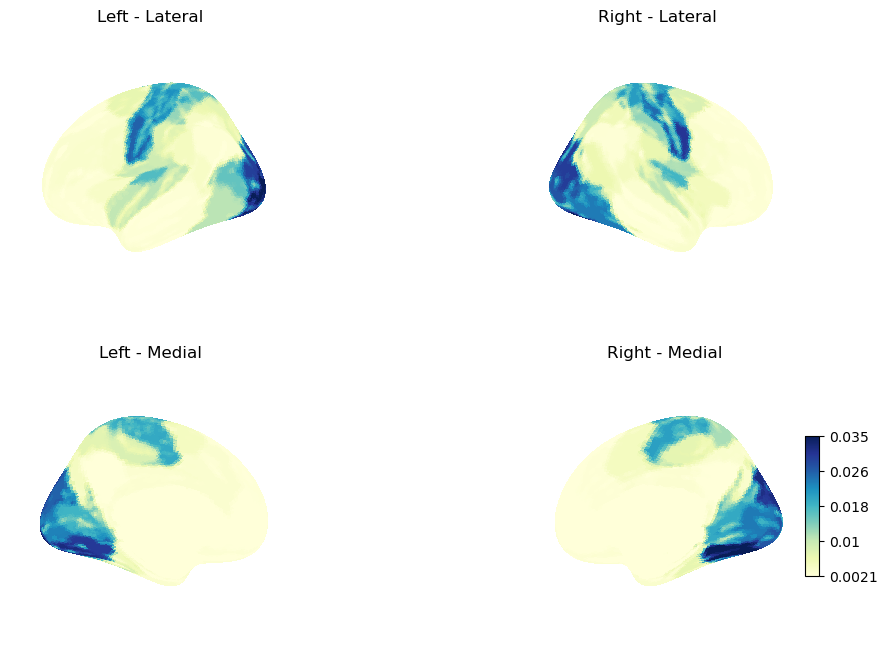

In [36]:
results_dir = os.path.join(output_dir, 'graphtrip', 'attention_weights')
results = pd.read_csv(os.path.join(results_dir, 'mean_attention_weights_original.csv'))
save_path = None if not save_figs else os.path.join(fig_subdir, 'mean_attention_weights_original.svg')
population_mean = results.mean(axis=0).values
plot_brain_surface(population_mean, 
                   atlas=data.atlas, 
                   cmap=CMAP_DEFAULT,
                   save_path=save_path);

if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, 'graphtrip_attention_weights')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    np.savetxt(os.path.join(brain_surface_subdir, 'mean_attention_weights_original.csv'), population_mean)

#### b. Linear predictors of regional attention

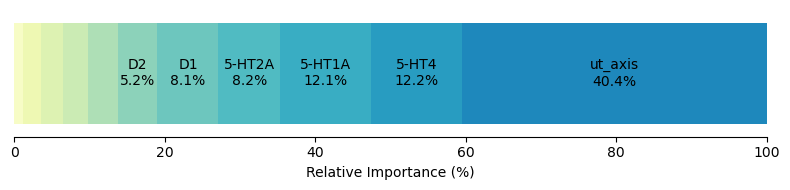

In [37]:
# Load results
results_dir = os.path.join(output_dir, 'graphtrip', 'attention_weights')
dominance_results = pd.read_csv(os.path.join(results_dir, 'da_receptors_utaxis_stats.csv'), index_col=0)
dominance_results = dominance_results.drop('analysis', axis=1)

# Plot stacked percentages
save_path = None if not save_figs else os.path.join(fig_subdir, 'dominance_analysis_original_stacked_percentages.svg')
offset = 5
palette = sns.color_palette("YlGnBu", len(dominance_results)+offset)
palette = palette[:-offset]
plot_stacked_percentages(df=dominance_results,
                         percentage_col='Percentage Relative Importance',
                         save_path=save_path,
                         palette=palette, 
                         figsize=(8, 2))

#### c. Mean attention in RSNs

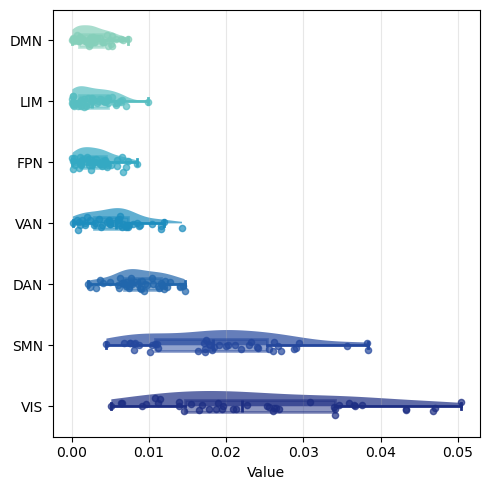

,RSN1,RSN2,tstat,pval,fdr,cohen_d
13,DAN,FPN,14.201484,1.994563e-17,4.188583e-16,2.039580
14,DAN,DMN,13.245952,2.104715e-16,2.209951e-15,2.238856
12,DAN,LIM,12.004805,5.295850e-15,3.283209e-14,2.022572
10,SMN,DMN,11.942775,6.253731e-15,3.283209e-14,2.591279
8,SMN,LIM,11.727574,1.117591e-14,4.693883e-14,2.521578
9,SMN,FPN,11.612571,1.527858e-14,5.347502e-14,2.517841
7,SMN,VAN,11.410413,2.658222e-14,7.974667e-14,2.049909
5,VIS,DMN,10.236690,7.351838e-13,1.929857e-12,2.492875
4,VIS,FPN,9.943154,1.734148e-12,4.040049e-12,2.442607
3,VIS,LIM,9.907902,1.923833e-12,4.040049e-12,2.448275


In [38]:
# Load mean RSN attention (with original context)
results_dir = os.path.join(output_dir, 'graphtrip', 'attention_weights')
rsn_attention_original = pd.read_csv(os.path.join(results_dir, 'mean_rsn_attention_weights_original.csv'))
rsn_names = rsn_attention_original.columns
n_rsns = len(rsn_names)

# Turn into dictionary for plotting
rsn_attention_original = rsn_attention_original.to_dict(orient='list')
rsn_attention_original = {k: v for k, v in sorted(rsn_attention_original.items(), key=lambda item: np.mean(item[1]), reverse=True)}

# Plot the raincloud plot
save_path = None if not save_figs else os.path.join(fig_subdir, 'mean_rsn_attention_original_raincloud.svg')
offset = 3
colors = sns.color_palette("YlGnBu_r", n_rsns+offset)
palette = {name: color for name, color in zip(rsn_attention_original.keys(), colors)}
plot_raincloud(rsn_attention_original, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.7, 
               box_alpha=0.5,
               figsize=(5, 5),
               sort_by_mean=False)

# Compare each pair of RSNs with a paired t-test
stats_df = {'RSN1': [], 'RSN2': [], 'tstat': [], 'pval': [], 'fdr': [], 'cohen_d': []}
for i, rsn1 in enumerate(rsn_names):
    for rsn2 in rsn_names[i+1:]:

        # Compute stats
        t_stat, p_val = stats.ttest_rel(rsn_attention_original[rsn1], rsn_attention_original[rsn2])
        d = (np.mean(rsn_attention_original[rsn1]) - np.mean(rsn_attention_original[rsn2])) / \
            np.sqrt((np.std(rsn_attention_original[rsn1])**2 + np.std(rsn_attention_original[rsn2])**2) / 2)
        
        # Store results
        stats_df['RSN1'].append(rsn1)
        stats_df['RSN2'].append(rsn2) 
        stats_df['tstat'].append(t_stat)
        stats_df['pval'].append(p_val)
        stats_df['cohen_d'].append(d)

# Convert to dataframe and calculate FDR
stats_df['fdr'] = fdrcorrection(stats_df['pval'])[1]
stats_df = pd.DataFrame(stats_df)
stats_df = stats_df.sort_values('pval')
stats_df

#### d. Treatment-specific attention shift 

,RSN,pval,tstat,cohen_d,fdr
0,VIS,2.738511e-10,-8.280483,-1.277706,6.291123e-10
1,SMN,1.684257e-05,-4.873336,-0.751972,2.357960e-05
2,DAN,6.320343e-01,-0.482475,-0.074448,6.320343e-01
3,VAN,8.969776e-05,4.344212,0.670327,1.046474e-04
4,DMN,1.250985e-11,9.280999,1.432089,8.756893e-11
5,LIM,3.594927e-10,8.193965,1.264356,6.291123e-10
6,FPN,1.663923e-10,8.439555,1.302252,5.823731e-10


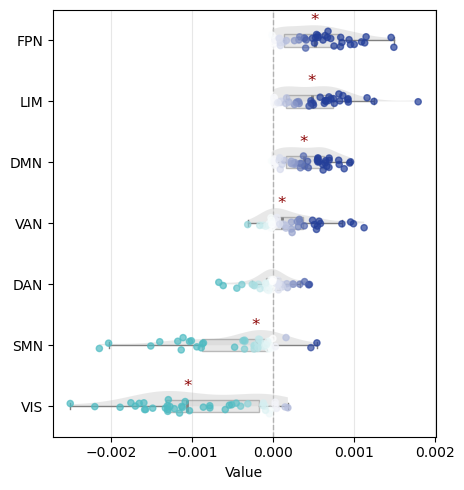

In [39]:
# Load the differences (psilo - escit) of mean RSN attention
results_dir = os.path.join(output_dir, 'graphtrip', 'attention_weights')
rsn_differences = pd.read_csv(os.path.join(results_dir, 'mean_rsn_attention_weights_context_diff.csv')).to_dict(orient='list')
rsn_differences = {k: v for k, v in sorted(rsn_differences.items(), key=lambda item: np.mean(item[1]))}

# Plot the diverging raincloud plot
save_path = None if not save_figs else os.path.join(fig_subdir, 'mean_rsn_attention_psilo-escit_diverging_raincloud.svg')
eso_psilo_cmap = custom_diverging_cmap(ESCIT, PSILO, n_colors=256)
plot_diverging_raincloud(rsn_differences, 
                         cmap=eso_psilo_cmap, 
                         vmax=0.0005, 
                         alpha=0.5, 
                         box_alpha=0.5, 
                         scatter_alpha=0.7,
                         save_path=save_path, 
                         figsize=(4.75, 5),
                         add_asterisk=True,
                         add_colorbar=False);

# Compute stats
stats_df = {'RSN': [], 
            'pval': [],
            'tstat': [],
            'cohen_d': [],
            'fdr': []}
for rsn, rsn_data in rsn_differences.items():
    # Compute stats
    t_stat, p_val = stats.ttest_1samp(rsn_data, 0)
    d = np.mean(rsn_data) / np.std(rsn_data, ddof=1)

    # Store
    stats_df['RSN'].append(rsn)
    stats_df['pval'].append(p_val)
    stats_df['tstat'].append(t_stat)
    stats_df['cohen_d'].append(d)

# FDR correction
stats_df['fdr'] = fdrcorrection(stats_df['pval'])[1]
stats_df = pd.DataFrame(stats_df)
stats_df

#### g. GRAIL biomarker results

In [40]:
# Load mean alignment results (CV-fold models averaged)
results_dir = os.path.join(output_dir, 'graphtrip', 'grail_posthoc')
mean_alignments = pd.read_csv(os.path.join(results_dir, 'mean_alignments.csv'))

# Load filtered features (biomarkers with abs(alignment) > 75 percentile)
feature_file = os.path.join(results_dir, 'features_filtered.json')
with open(feature_file, 'r') as f:
    filtered_features = json.load(f)
filtered_features = sort_features(filtered_features) # sort by feature category

# Load cluster labels and conditions
cluster_labels = np.loadtxt(os.path.join(results_dir, 'cluster_labels.csv'))

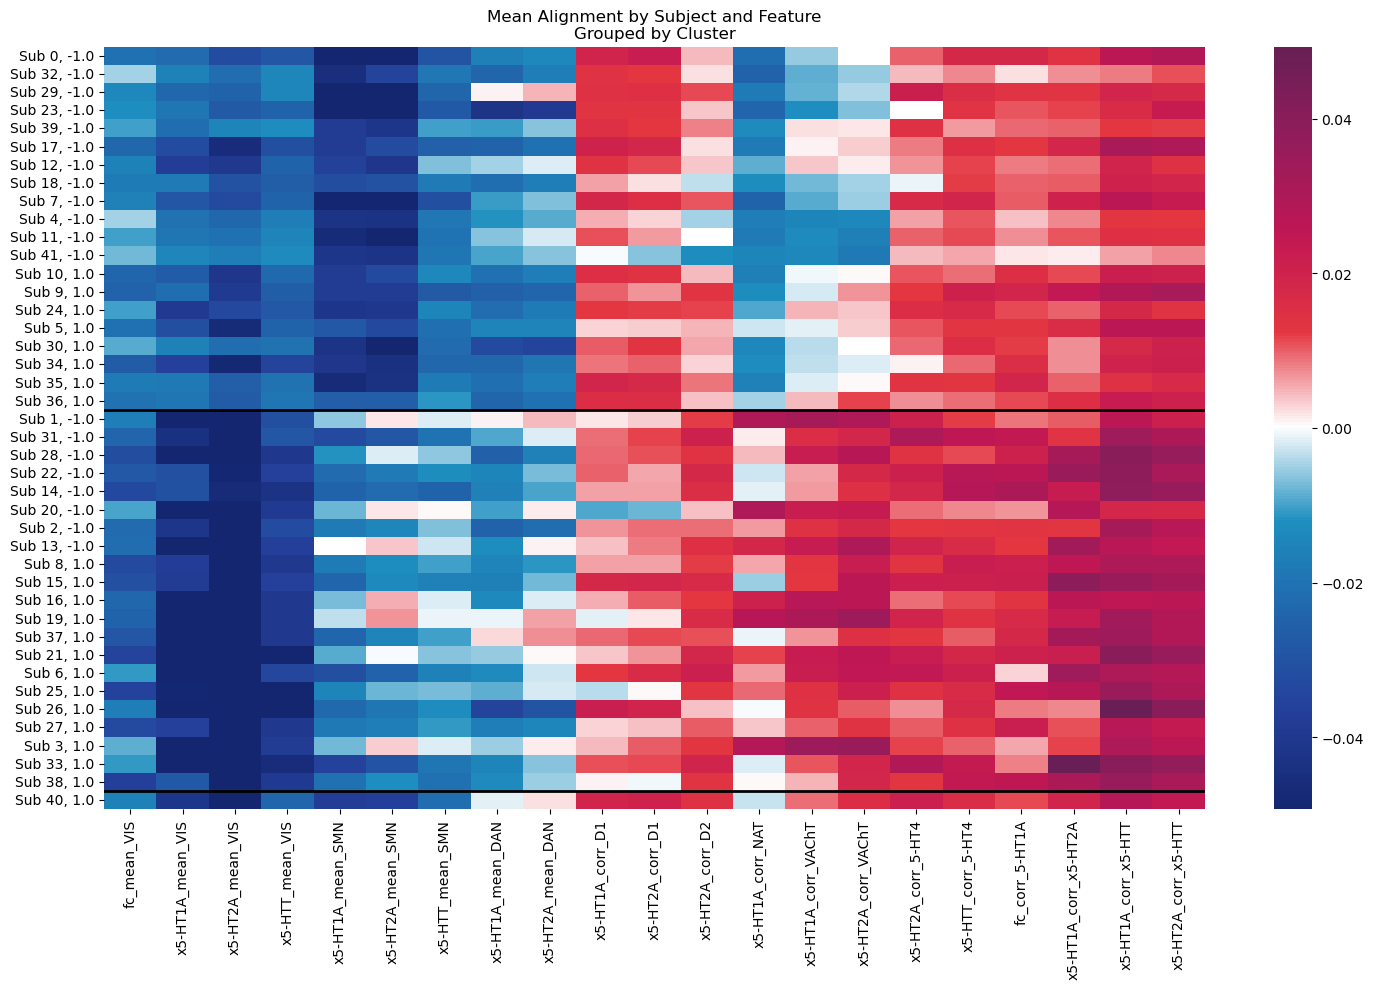

In [41]:
# Plot biomarker alignments
save_path = None if not save_figs else os.path.join(fig_subdir, 'mean_alignment_matrix.svg')
vmax = np.percentile(abs(mean_alignments[filtered_features].values), 95)
vrange = (-vmax, vmax)
plot_clustered_matrix(mean_alignments[filtered_features].values, 
                      labels=cluster_labels, 
                      conditions=conditions,
                      features=filtered_features, 
                      cmap=COOLWARM,
                      vrange=vrange,
                      save_path=save_path)

## Fig. 6: Causal modelling with X-graphTRIP

In [42]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.6')
os.makedirs(fig_subdir, exist_ok=True)

#### b-c. ITE predictions

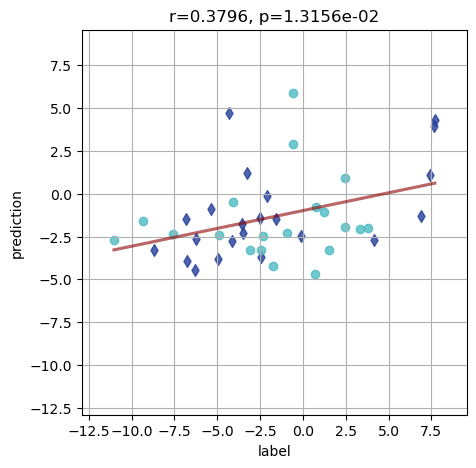

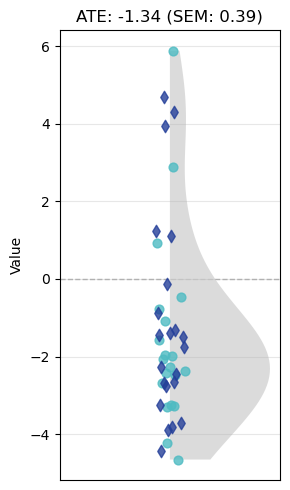

In [43]:
# Load results
results_dir = os.path.join(output_dir, 'x_graphtrip', 'weights', 'job_0')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))

# Plot pseudo-ITE labels vs predicted ITEs
save_path = None if not save_figs else os.path.join(fig_subdir, 'x_graphtrip_true_vs_pred.svg')
regression_scatter(results, 
                   show_ci=False,
                   equal_aspect=True,
                   regline_alpha=0.6,
                   save_path=save_path)

# Plot ITE violin
save_path = None if not save_figs else os.path.join(fig_subdir, 'x_graphtrip_ite_violin.svg')
plot_ite_violin(results, save_path=save_path)

#### d. Attention weights analysis

In [44]:
# Load the performance-weighted mean attention weights of all subjects
results_dir = os.path.join(output_dir, 'x_graphtrip', 'attention_weights', 'pls_analysis')
attention_weights = pd.read_csv(os.path.join(results_dir, 'weighted_means_significant.csv'))

# Save patient-mean attention weights to plot with MATLAB
if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, 'x_graphtrip_weighted_mean_attention')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    patient_means = attention_weights.mean(axis=0).values
    np.savetxt(os.path.join(brain_surface_subdir, 'weighted_means_attention.csv'), patient_means, delimiter=',')

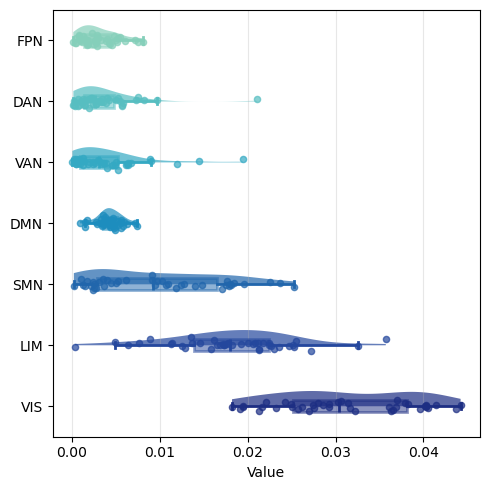

,RSN1,RSN2,tstat,pval,fdr,cohen_d
4,VIS,FPN,23.127355,3.832789e-25,8.048857e-24,5.093973
5,VIS,DMN,21.582494,5.286664e-24,5.550997e-23,4.949301
1,VIS,DAN,18.535675,1.535422e-21,1.074795e-20,4.669314
2,VIS,VAN,18.356464,2.193047e-21,1.151349e-20,4.493433
18,LIM,FPN,14.465198,1.060436e-17,4.453832e-17,2.989990
12,DAN,LIM,-12.319133,2.297814e-15,8.042350e-15,-2.661307
19,LIM,DMN,11.867970,7.647044e-15,2.294113e-14,2.796414
15,VAN,LIM,-10.922328,1.034486e-13,2.715527e-13,-2.515844
0,VIS,SMN,10.007595,1.435014e-12,3.348366e-12,2.929119
3,VIS,LIM,7.014709,1.571005e-08,3.299110e-08,1.796033


In [45]:
# Load the RSN-mean attention weights
results_dir = os.path.join(output_dir, 'x_graphtrip', 'attention_weights', 'pls_analysis')
rsn_attention = pd.read_csv(os.path.join(results_dir, 'weighted_mean_rsn_attention.csv'))
rsn_names = rsn_attention.columns
n_rsns = len(rsn_names)

# Turn into dictionary for plotting
rsn_attention = rsn_attention.to_dict(orient='list')
rsn_attention = {k: v for k, v in sorted(rsn_attention.items(), key=lambda item: np.mean(item[1]), reverse=True)}

# Plot the raincloud plot
save_path = None if not save_figs else os.path.join(fig_subdir, 'x_graphtrip_mean_rsn_attention_raincloud.svg')
offset = 3
colors = sns.color_palette("YlGnBu_r", n_rsns+offset)
palette = {name: color for name, color in zip(rsn_attention.keys(), colors)}
plot_raincloud(rsn_attention, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.7, 
               box_alpha=0.5,
               figsize=(5, 5),
               sort_by_mean=False)

# Compare each pair of RSNs with a paired t-test
stats_df = {'RSN1': [], 'RSN2': [], 'tstat': [], 'pval': [], 'fdr': [], 'cohen_d': []}
for i, rsn1 in enumerate(rsn_names):
    for rsn2 in rsn_names[i+1:]:

        # Compute stats
        t_stat, p_val = stats.ttest_rel(rsn_attention[rsn1], rsn_attention[rsn2])
        d = (np.mean(rsn_attention[rsn1]) - np.mean(rsn_attention[rsn2])) / \
            np.sqrt((np.std(rsn_attention[rsn1])**2 + np.std(rsn_attention[rsn2])**2) / 2)
        
        # Store results
        stats_df['RSN1'].append(rsn1)
        stats_df['RSN2'].append(rsn2) 
        stats_df['tstat'].append(t_stat)
        stats_df['pval'].append(p_val)
        stats_df['cohen_d'].append(d)

# Convert to dataframe and calculate FDR
stats_df['fdr'] = fdrcorrection(stats_df['pval'])[1]
stats_df = pd.DataFrame(stats_df)
stats_df = stats_df.sort_values('pval')
stats_df

#### e. GRAIL biomarker analysis

In [46]:
# Load the performance-weighted mean biomarker alignments
results_dir = os.path.join(output_dir, 'x_graphtrip', 'grail', 'pls_analysis')
weighted_mean_grail = pd.read_csv(os.path.join(results_dir, 'weighted_means_significant.csv'))
features_sorted = sort_features(list(weighted_mean_grail.columns))

# Load robust features
with open(os.path.join(results_dir, 'robust_features.json'), 'r') as f:
    robust_features = json.load(f)
escitalopram_features = robust_features['escitalopram']
psilocybin_features = robust_features['psilocybin']

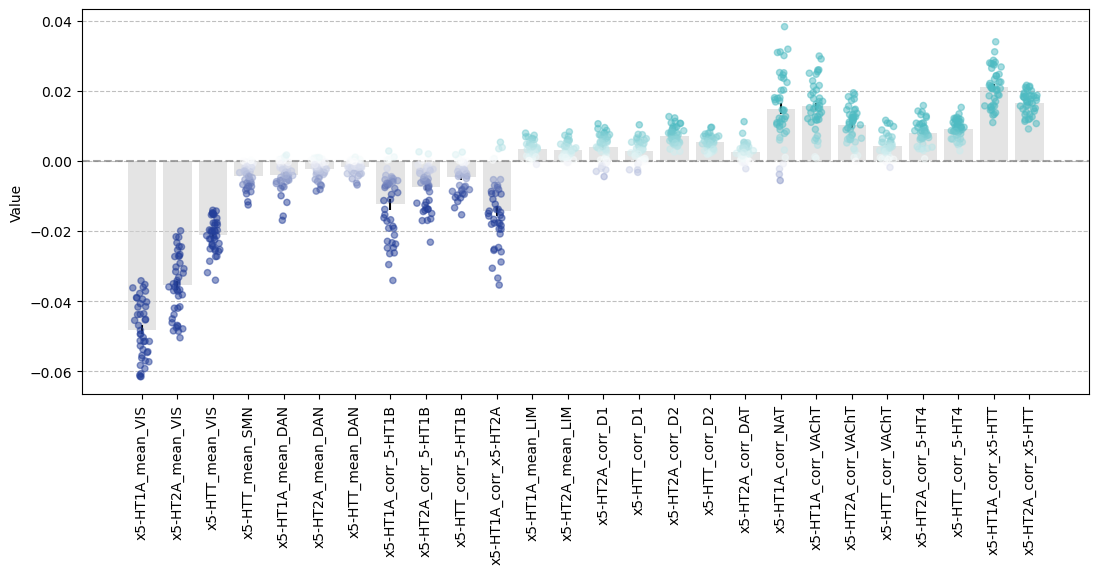

In [47]:
# Plot all robust features
save_path = None if not save_figs else os.path.join(fig_subdir, 'x_graphtrip_weighted_mean_grail_all_features.svg')
features_sorted = psilocybin_features + escitalopram_features
psilo_escit_cmap = custom_diverging_cmap(PSILO, ESCIT, n_colors=256)
vmax = 0.01
barwidth = 0.65
fig_size = (min(13, len(features_sorted)*barwidth), 5)
fig, ax = plot_diverging_bars(weighted_mean_grail[features_sorted], 
                    yline=0, 
                    cmap=psilo_escit_cmap, 
                    vmax=vmax, 
                    alpha=0.6,
                    add_scatter=True, 
                    scatter_alpha=0.5, 
                    scatter_size=20,
                    figsize=fig_size,
                    save_path=save_path,
                    add_colorbar=False)

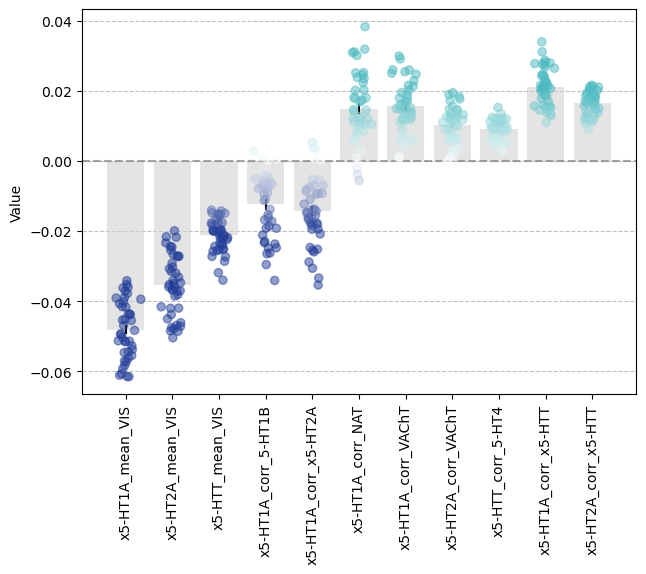

In [48]:
# Plot robust features with abs alignment > 75 percentile
save_path = None if not save_figs else os.path.join(fig_subdir, 'x_graphtrip_weighted_mean_grail_75pct_features.svg')
features_sorted = psilocybin_features + escitalopram_features

# Filter features where absolute mean exceeds threshold
threshold = np.percentile(abs(weighted_mean_grail.values.flatten()), 75)
filtered_features = [f for f in features_sorted 
                    if abs(weighted_mean_grail[f].mean()) > threshold]

# Plot filtered features
psilo_escit_cmap = custom_diverging_cmap(PSILO, ESCIT, n_colors=256)
vmax = 0.02
barwidth = 0.65
fig_size = (min(13, len(filtered_features)*barwidth), 5)
fig, ax = plot_diverging_bars(weighted_mean_grail[filtered_features], 
                    yline=0, 
                    cmap=psilo_escit_cmap, 
                    vmax=vmax, 
                    alpha=0.6,
                    add_scatter=True, 
                    scatter_alpha=0.5, 
                    scatter_size=35,
                    figsize=fig_size,
                    save_path=save_path,
                    add_colorbar=False)

---
# Supplementary

In [49]:
# Define output directory for supplementary
sm_figure_dir = os.path.join(figure_dir, 'SUPPLEMENTARY')
os.makedirs(sm_figure_dir, exist_ok=True)

## Generalisation to edges defined based on fixed connection density FC

In [50]:
# Define output directory for model performance
suboutput_dir = os.path.join(sm_figure_dir, 'fixed_connection_density')
os.makedirs(suboutput_dir, exist_ok=True)

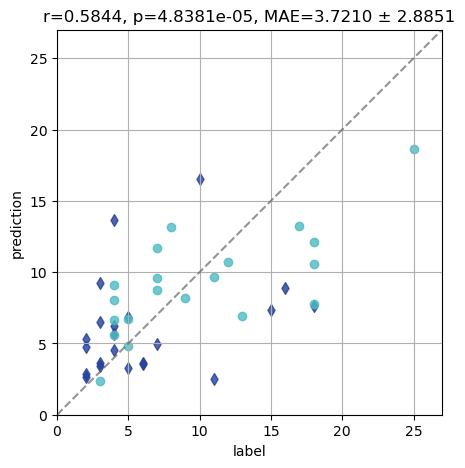

In [51]:
# graphTRIP evaluated on dataset with fixed connection density (show transfer/ generalisation)
results_dir = os.path.join(output_dir, 'graphtrip', 'fixed_connection_density')
results = pd.read_csv(os.path.join(results_dir, 'initial_prediction_results.csv'))
save_path = None if not save_figs else os.path.join(suboutput_dir, 'true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

Loading model configurations.


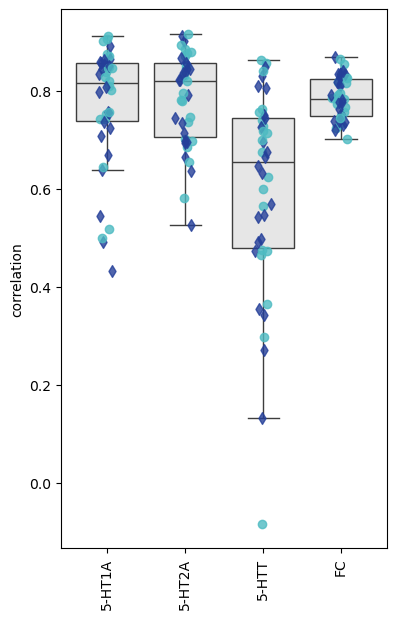

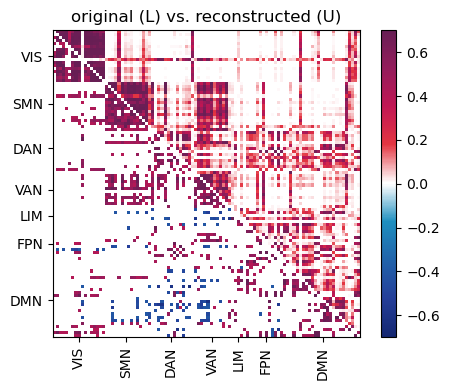

In [52]:
# Load fixed density dataset
results_dir = os.path.join(output_dir, 'graphtrip', 'fixed_connection_density')
fd_config = load_ingredient_configs(results_dir, ingredients=['dataset'])
fd_data = load_dataset(fd_config['dataset'])

# Get reconstructions from the new data, using the same VGAEs as the original model
test_indices_list = [np.where(test_indices == fold)[0] for fold in range(num_folds)]
adj_orig_rcn, x_orig_rcn, fold_assignments = get_test_reconstructions(vgaes, fd_data, test_indices_list, mean_std=None)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(adj_orig_rcn)
x_orig_rcn['metrics'] = evaluate_x_reconstructions(x_orig_rcn)
x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(suboutput_dir, 'original_vs_recon_corrs.svg')
plot_metric_boxplot(x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

# Plot the full original vs. reconstructed FC of an example subject
sub = 0
save_path = None if not save_figs else os.path.join(suboutput_dir, f'fc_original_vs_recon_sub{sub}.svg')
vrange = (-0.7, 0.7)
plot_fc_reconstruction_single(adj_orig_rcn, sub, 
                              rsn_mapping=rsn_mapping, 
                              rsn_labels=rsn_names, 
                              cmap=COOLWARM, 
                              vrange=vrange,
                              save_path=save_path)

## Benchmarks (PCA, t-SNE)

In [53]:
# Define output directory for model performance
fig_subdir = os.path.join(sm_figure_dir, 'benchmarks')
os.makedirs(fig_subdir, exist_ok=True)

#### PCA benchmark

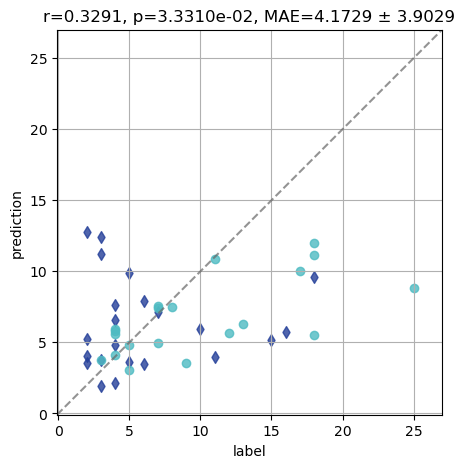

In [54]:
# Load prediction results
results_dir = os.path.join(output_dir, 'benchmarks', 'pca_benchmark')
pred_results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))
pred_results.head()
save_path = None if not save_figs else os.path.join(fig_subdir, 'pca_true_vs_predicted.svg')
true_vs_pred_scatter(pred_results, save_path=save_path)

#### t-SNE benchmark

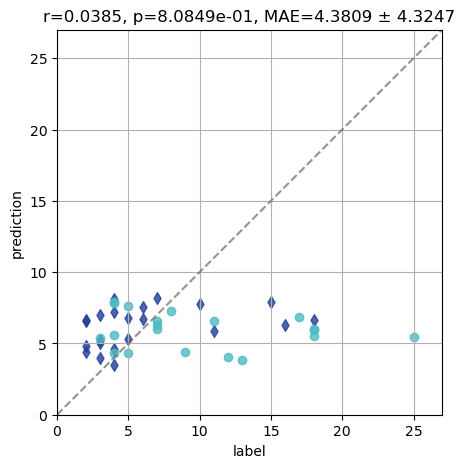

In [55]:
# Load prediction results
results_dir = os.path.join(output_dir, 'benchmarks', 'tsne_benchmark')
pred_results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))
pred_results.head()
save_path = None if not save_figs else os.path.join(fig_subdir, 'tsne_true_vs_predicted.svg')
true_vs_pred_scatter(pred_results, save_path=save_path)

## Predicting post-treatment BDI

In [56]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'predicting_bdi')
os.makedirs(fig_subdir, exist_ok=True)

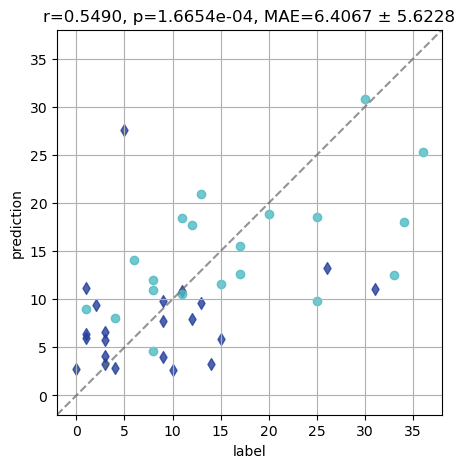

In [57]:
# BDI prediction results
results_dir = os.path.join(output_dir, 'graphtrip_bdi', 'weights')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))
save_path = None if not save_figs else os.path.join(fig_subdir, 'true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

Loading model configurations.


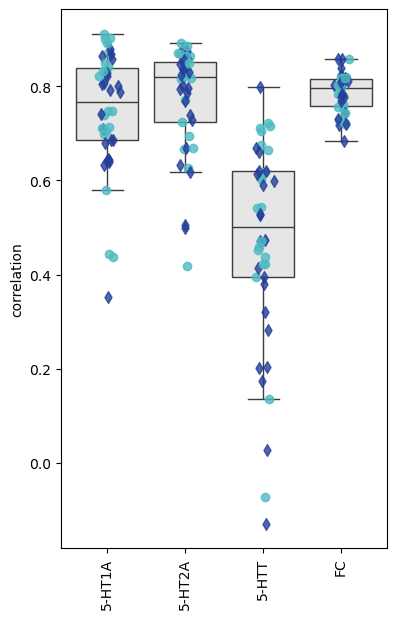

In [58]:
# Load BDI dataset
results_dir = os.path.join(output_dir, 'graphtrip_bdi', 'weights')
bdi_config = load_ingredient_configs(results_dir, ingredients=['dataset', 'vgae_model'])
bdi_data = load_dataset(bdi_config['dataset'])

# Load trained VGAEs
bdi_weight_filenames = get_weight_filenames_from_config(bdi_config)
bdi_vgaes = load_vgaes(bdi_config['vgae_model'], 
                       results_dir, 
                       bdi_weight_filenames['vgae'])

# Get VGAE reconstructions
bdi_test_indices = np.loadtxt(os.path.join(results_dir, bdi_weight_filenames['test_fold_indices'][0]), dtype=int)
bdi_test_indices_list = [np.where(bdi_test_indices == fold)[0] for fold in range(num_folds)]
adj_orig_rcn, x_orig_rcn, _ = get_test_reconstructions(bdi_vgaes, 
                                                       bdi_data, 
                                                       bdi_test_indices_list, 
                                                       mean_std=None)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(adj_orig_rcn)
x_orig_rcn['metrics'] = evaluate_x_reconstructions(x_orig_rcn)
x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, 'original_vs_recon_corrs.svg')
plot_metric_boxplot(x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

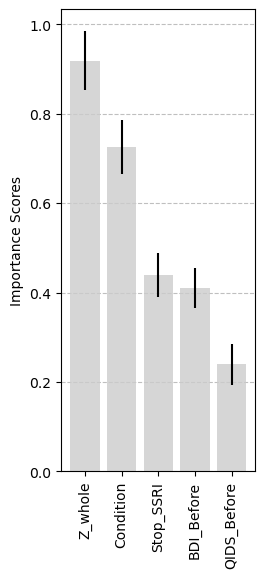

In [59]:
# Permutation Importance
results_dir = os.path.join(output_dir, 'graphtrip_bdi', 'permutation_importance')
results = pd.read_csv(os.path.join(results_dir, 'importance_scores_aggregated.csv'))

# Sort the rows of results by mean importance score
results = results.sort_values(by='mean', ascending=False)
save_path = None if not save_figs else os.path.join(fig_subdir, 'importance_scores_aggregated.svg')
permutation_importance_bar_chart(results, yerr_column='se', color=NEUTRAL, alpha=0.8, save_path=save_path)

## Generalisation to AAL brain atlas

In [60]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'aal_atlas')
os.makedirs(fig_subdir, exist_ok=True)

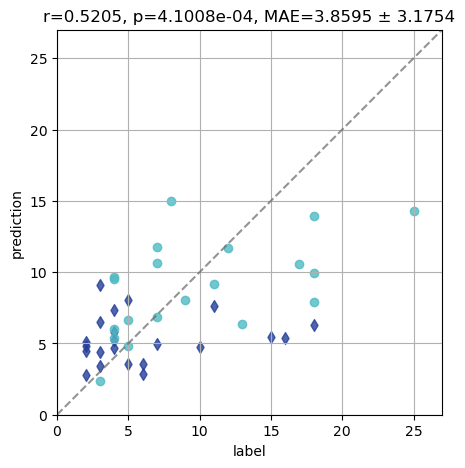

In [61]:
# AAL 116 atlas
atlas = 'aal'
results_dir = os.path.join(output_dir, 'graphtrip', 'transfer_atlas', atlas)
results = pd.read_csv(os.path.join(results_dir, 'initial_prediction_results.csv'))
save_path = None if not save_figs else os.path.join(fig_subdir, f'true_vs_pred_{atlas}.svg')
true_vs_pred_scatter(results, save_path=save_path)

In [62]:
# Load Schaefer 200 data
atlas_config = load_ingredient_configs(results_dir, ingredients=['dataset'])
atlas_data = load_dataset(atlas_config['dataset'])

# Get new rsn_mapping for Schaefer 200
atlas_rsn_mapping, atlas_rsn_labels = get_rsn_mapping(atlas_data.atlas)

# Get reconstructions from the new data, using the same VGAEs as the original model
test_indices_list = [np.where(test_indices == fold)[0] for fold in range(num_folds)]
adj_orig_rcn, x_orig_rcn, fold_assignments = get_test_reconstructions(vgaes, atlas_data, test_indices_list, mean_std=None)

# Example subject
sub = 0

Loading model configurations.


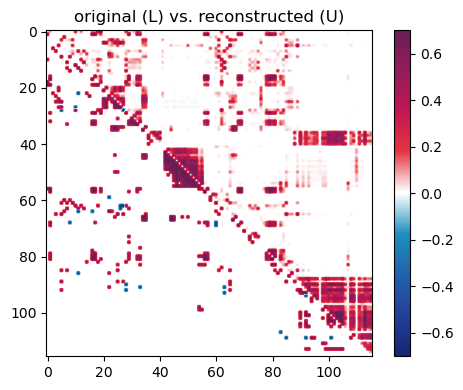

In [63]:
# Plot FC reconstructions
vrange = (-0.7, 0.7)
cmap = COOLWARM
save_path = None if not save_figs else os.path.join(fig_subdir, f'fc_reconstruction_sub{sub}_{atlas}.svg')
plot_fc_reconstruction_single(adj_orig_rcn, 
                              rsn_mapping=atlas_rsn_mapping, 
                              rsn_labels=atlas_rsn_labels, 
                              subject_idx=sub,
                              cmap=cmap, 
                              vrange=vrange,
                              save_path=save_path)

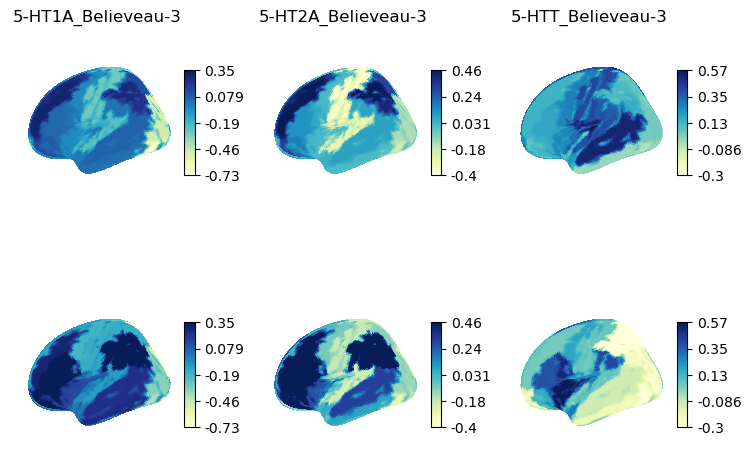

In [64]:
save_path = None if not save_figs else os.path.join(fig_subdir, f'x_reconstructions_sub{sub}_{atlas}.png')
original = x_orig_rcn['original'][:, :, sub]
reconstructed = x_orig_rcn['reconstructed'][:, :, sub]
data2plot = np.stack([reconstructed, original], axis=0)
plot_brain_surface_grid(data2plot, 
                        atlas=atlas_data.atlas, 
                        view='medial',
                        cmap=x_cmaps,
                        column_names=x_orig_rcn['feature_names'],
                        save_path=save_path);

if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, f'{atlas}_reconstructions')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    reconstructed_df = pd.DataFrame(reconstructed, columns=x_orig_rcn['feature_names'])
    original_df = pd.DataFrame(original, columns=x_orig_rcn['feature_names'])
    reconstructed_df.to_csv(os.path.join(brain_surface_dir, f'reconstructed_sub{sub}_{atlas}.csv'), index=False)
    original_df.to_csv(os.path.join(brain_surface_dir, f'original_sub{sub}_{atlas}.csv'), index=False)

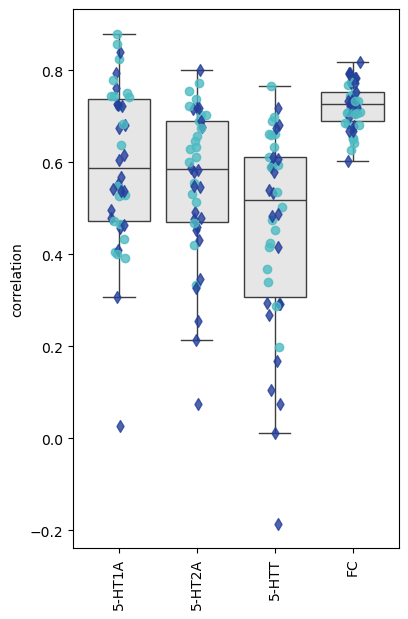

In [65]:
# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(adj_orig_rcn)
x_orig_rcn['metrics'] = evaluate_x_reconstructions(x_orig_rcn)

# Add FC correlations to x metrics (to plot together)
x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, f'original_vs_reconstructed_corrs_{atlas}.svg')
plot_metric_boxplot(x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

## CV-model agreement (graphTRIP)

In [66]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'cv_model_corrs_graphTRIP')
os.makedirs(fig_subdir, exist_ok=True)

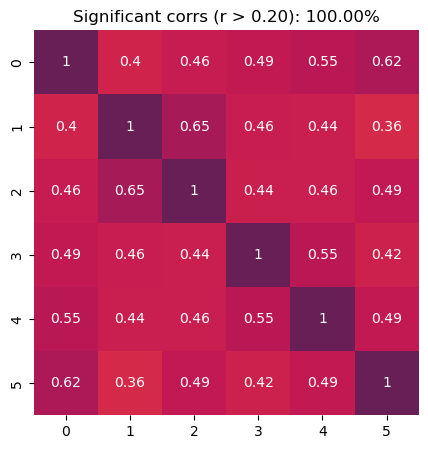

In [67]:
# Load CV-fold model correlations of attention weights
results_dir = os.path.join(output_dir, 'graphtrip', 'attention_weights')
mean_corr_matrix = pd.read_csv(os.path.join(results_dir, 'mean_fold_correlations.csv'), header=None)

# Plot mean correlation matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(mean_corr_matrix.values, 
            ax=ax, 
            cmap=COOLWARM, 
            vmin=-1, vmax=1, 
            square=True, 
            annot=True, 
            cbar=False)

# Calculate minimum significant r value
num_features = num_nodes # number of brain regions
r_critical = min_significant_r(num_features)

# Calculate fraction of significant pairs
num_unique_pairs = num_folds * (num_folds - 1) / 2
num_significant_pairs = np.sum(np.triu(mean_corr_matrix, k=1) > r_critical)
fraction_significant_pairs = (num_significant_pairs / num_unique_pairs)*100
ax.set_title(f'Significant corrs (r > {r_critical:.2f}): {fraction_significant_pairs:.2f}%');

# Save figure
if save_figs:
    save_path = os.path.join(fig_subdir, 'mean_fold_corrs_attention.svg')
    plt.savefig(save_path)

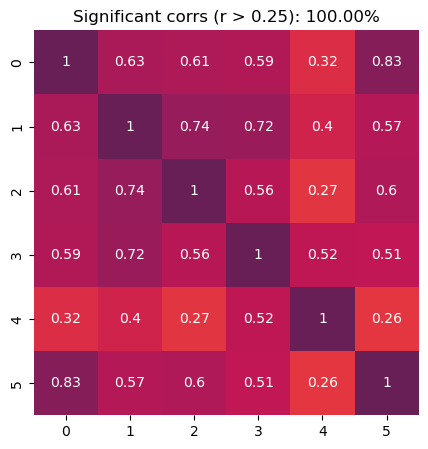

In [68]:
# Load CV-fold model correlations of GRAIL patterns
results_dir = os.path.join(output_dir, 'graphtrip', 'grail')
mean_alignments = pd.read_csv(os.path.join(results_dir, 'k0_mean_alignments.csv'))
mean_corr_matrix = pd.read_csv(os.path.join(results_dir, 'mean_fold_correlations.csv'), header=None)

# Plot mean correlation matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(mean_corr_matrix.values, 
            ax=ax, 
            cmap=COOLWARM, 
            vmin=-1, vmax=1, 
            square=True, 
            annot=True, 
            cbar=False)

# Calculate minimum significant r value
num_features = mean_alignments.shape[1]
r_critical = min_significant_r(num_features)

# Calculate fraction of significant pairs
num_unique_pairs = num_folds * (num_folds - 1) / 2
num_significant_pairs = np.sum(np.triu(mean_corr_matrix, k=1) > r_critical)
fraction_significant_pairs = (num_significant_pairs / num_unique_pairs)*100
ax.set_title(f'Significant corrs (r > {r_critical:.2f}): {fraction_significant_pairs:.2f}%');

# Save figure
if save_figs:
    save_path = os.path.join(fig_subdir, 'mean_fold_corrs_grail.svg')
    plt.savefig(save_path)

## Drug differences in biomarker aligmnents (graphTRIP) 

In [69]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'alignment_drug_diffs')
os.makedirs(fig_subdir, exist_ok=True)

In [70]:
# Load mean alignment results (CV-fold models averaged)
results_dir = os.path.join(output_dir, 'graphtrip', 'grail_posthoc')
mean_alignments = pd.read_csv(os.path.join(results_dir, 'mean_alignments.csv'))

# Load filtered features (biomarkers with abs(alignment) > 75 percentile)
feature_file = os.path.join(results_dir, 'features_filtered.json')
with open(feature_file, 'r') as f:
    filtered_features = json.load(f)
filtered_features = sort_features(filtered_features) # sort by feature category

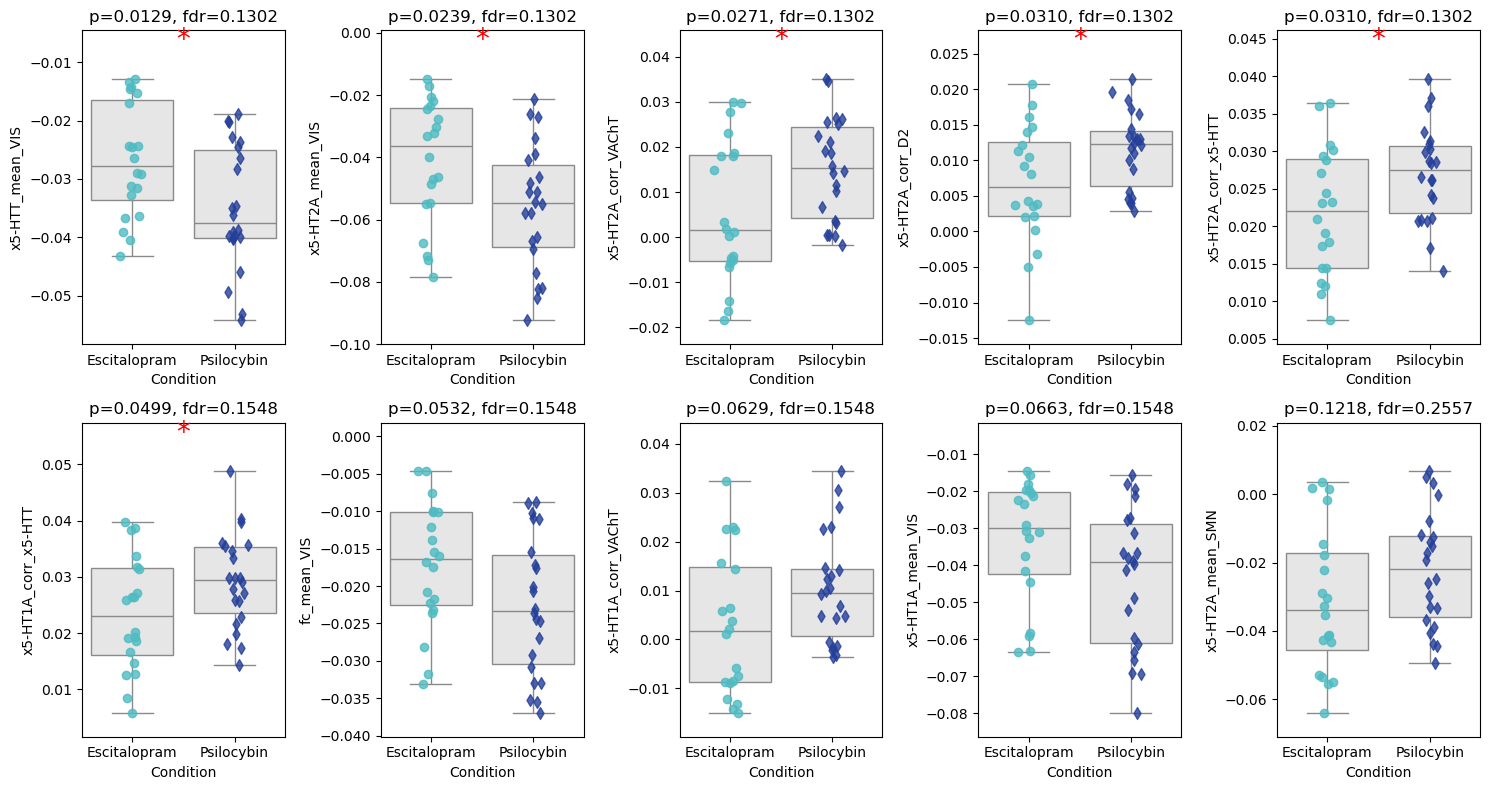

In [71]:
# Prepare data for plotting
plot_df = mean_alignments.copy()
plot_df['Condition'] = conditions
plot_df['Condition'] = plot_df['Condition'].map({-1: 'Escitalopram', 1: 'Psilocybin'})

# Compute stats to compare alignment values between conditions
stats_df = pd.DataFrame(columns=['feature', 'tstat', 'pval', 'cohens_d'])
for i, feat in enumerate(filtered_features):
    data_escit = plot_df[plot_df['Condition'] == 'Escitalopram'][feat]
    data_psilo = plot_df[plot_df['Condition'] == 'Psilocybin'][feat]
    tstat, pval = stats.ttest_ind(data_escit, data_psilo)
    cohend = (data_psilo.mean() - data_escit.mean()) / np.sqrt((data_psilo.std()**2 + data_escit.std()**2) / 2)
    stats_df.loc[i] = [feat, tstat, pval, cohend]
stats_df['fdr_pval'] = fdrcorrection(stats_df['pval'])[1]

# Plot the 10 most significant candidate biomarkers
stats_df = stats_df.sort_values('pval').head(10)
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 4*n_rows))
axes = axes.flatten()

for i, (_, row) in enumerate(stats_df.iterrows()):
    feat = row['feature']
    ax = axes[i]
    
    # Plot distributions
    sns.boxplot(data=plot_df, x='Condition', y=feat, ax=ax, color=BOX_COLOR, showfliers=False, zorder=1)
    for j, c in enumerate(['Escitalopram', 'Psilocybin']):
        mask = plot_df['Condition'] == c
        x_jitter = np.random.normal(j, 0.05, size=sum(mask))
        marker = 'o' if c == 'Escitalopram' else 'd'
        color = ESCIT if c == 'Escitalopram' else PSILO
        ax.scatter(x_jitter, plot_df[mask][feat], marker=marker, color=color, alpha=ALPHA_SCATTER, zorder=2)

    # Get current y-axis limits and data range
    data_escit = plot_df[plot_df['Condition'] == 'Escitalopram'][feat]
    data_psilo = plot_df[plot_df['Condition'] == 'Psilocybin'][feat]
    data_min = min(data_escit.min(), data_psilo.min())
    data_max = max(data_escit.max(), data_psilo.max())
    data_range = data_max - data_min
    
    # Set new y limits with padding for asterisk
    new_ymax = data_max + 0.2 * data_range
    new_ymin = data_min - 0.1 * data_range
    ax.set_ylim(new_ymin, new_ymax)
    if row['pval'] < 0.05:
        ax.text(0.5, data_max + 0.1 * data_range, '*', color='red', ha='center', va='bottom', fontsize=20)

    # Set x-ticks and labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Escitalopram', 'Psilocybin'])
    ax.set_title(f'p={row["pval"]:.4f}, fdr={row["fdr_pval"]:.4f}')
    ax.set_ylabel(feat)

plt.tight_layout()
# Save figure
if save_figs:
    save_path = os.path.join(fig_subdir, 'graphTRIP_alignment_diffs_between_conditions.svg')
    plt.savefig(save_path)

## GRAIL method validation

In [72]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'grail_validation')
os.makedirs(fig_subdir, exist_ok=True)

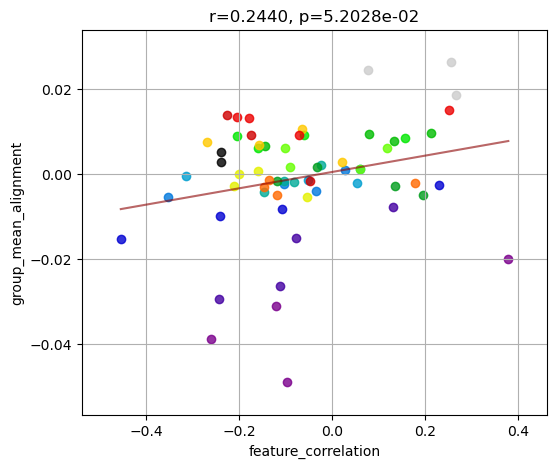

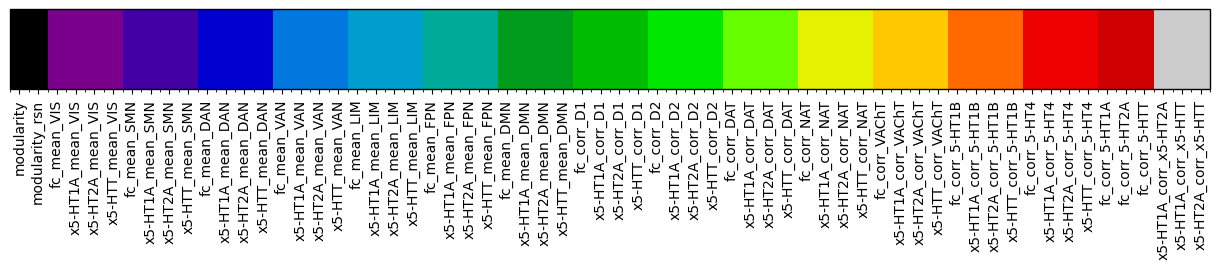

In [73]:
# Load mean alignment results (CV-fold models averaged)
results_dir = os.path.join(output_dir, 'graphtrip', 'grail_posthoc')
mean_alignments = pd.read_csv(os.path.join(results_dir, 'mean_alignments.csv'))

# Load correlations between biomarkers and post-treatment QIDS
results_dir = os.path.join(output_dir, 'graphtrip', 'test_biomarkers')
feature_corrs = pd.read_csv(os.path.join(results_dir, 'feature_correlations.csv'))

# Create a colour palette for each biomarker category
feature_names = feature_corrs['feature'].tolist()
groups = get_groups(feature_names)
colors = plot_colormap_stack('nipy_spectral', len(groups), make_plot=False)
palette = {}
for i, group in enumerate(groups):
    color = colors[i]
    for feature in group:
        palette[feature] = color

# Average gradient alignment values across patients to get global values
group_mean_alignments = mean_alignments[feature_names].mean(axis=0)

# Plot group-mean alignment vs feature correlations
save_path = None if not save_figs else os.path.join(fig_subdir, 'group_mean_alignment_vs_feature_corrs.svg')
plot_df = pd.DataFrame({'feature_correlation': feature_corrs['corr'].values, 
                        'group_mean_alignment': group_mean_alignments.values,
                        'feature': feature_names})
regression_scatter2(plot_df, 
                    xcol='feature_correlation', 
                    ycol='group_mean_alignment', 
                    ylim = None,
                    xlim = None,
                    featcol='feature',
                    palette=palette,
                    equal_aspect=False,
                    save_path=save_path)
plot_legend(palette, orientation='horizontal', size=(15, 1), label=None)

## Drug classifier results

#### a. Drug classifier trained on graphTRIP input features

In [74]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'graphtrip_drug_classifier')
os.makedirs(fig_subdir, exist_ok=True)

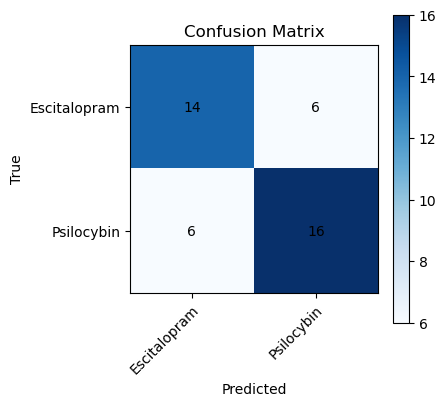

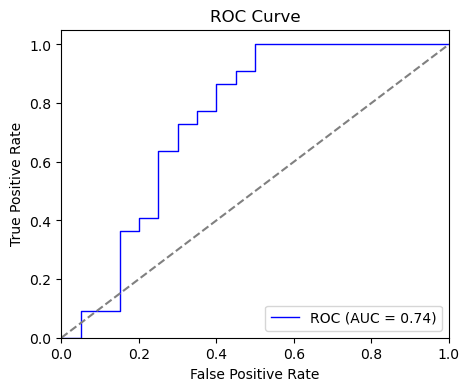

In [75]:
# Load drug-classifier training results
results_dir = os.path.join(output_dir, 'drug_classifier', 'weights')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))

# Plot confusion matrix
save_path = None if not save_figs else os.path.join(fig_subdir, 'confusion_matrix.svg')
plot_confusion_matrix(results['prediction'], results['label'], threshold=0.5, save_path=save_path)

# Plot ROC curve
save_path = None if not save_figs else os.path.join(fig_subdir, 'roc_curve.svg')
plot_roc_curve(results['prediction'], results['label'], figsize=(5, 4), save_path=save_path)

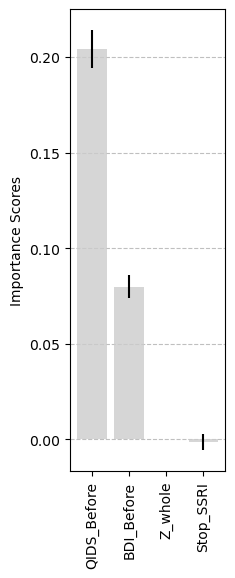

In [76]:
# Plot permutation importance analysis results to see what makes treatment predictable
results_dir = os.path.join(output_dir, 'drug_classifier', 'permutation_importance')
results = pd.read_csv(os.path.join(results_dir, 'importance_scores_aggregated.csv'))
results = results.sort_values(by='mean', ascending=False)
save_path = None if not save_figs else os.path.join(fig_subdir, 'importance_scores_aggregated.svg')
permutation_importance_bar_chart(results, yerr_column='se', color=NEUTRAL, alpha=0.8, save_path=save_path)

#### b. Drug classifier trained on X-graphTRIP representations

In [77]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'x_graphtrip_drug_classifier')
os.makedirs(fig_subdir, exist_ok=True)

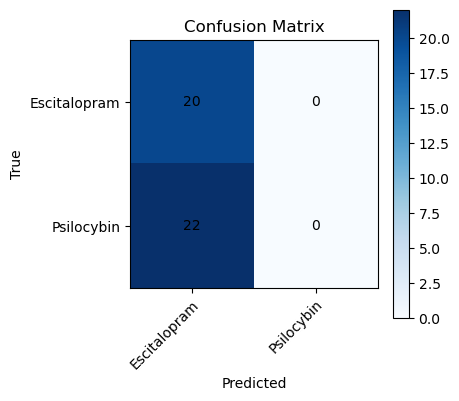

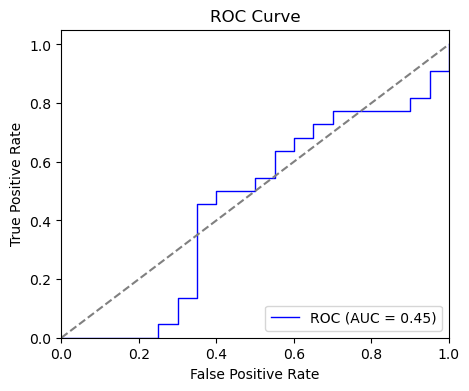

In [78]:
# Load drug-classifier training results (for the main X-graphTRIP model: job 0)
results_dir = os.path.join(output_dir, 'x_graphtrip', 'drug_classifier', 'job_0')
results = pd.read_csv(os.path.join(results_dir, 'prediction_results.csv'))

# Plot confusion matrix
save_path = None if not save_figs else os.path.join(fig_subdir, 'confusion_matrix.svg')
plot_confusion_matrix(results['prediction'], results['label'], threshold=0.5, save_path=save_path)

# Plot ROC curve
save_path = None if not save_figs else os.path.join(fig_subdir, 'roc_curve.svg')
plot_roc_curve(results['prediction'], results['label'], figsize=(5, 4), save_path=save_path)

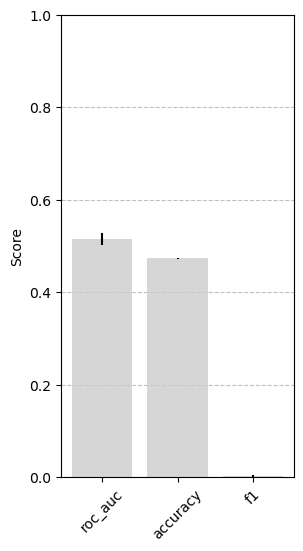

In [79]:
# Load drug-classifier training results from all other jobs
results_dir = os.path.join(output_dir, 'x_graphtrip', 'drug_classifier')
job_dirs = [d for d in os.listdir(results_dir) if d.startswith('job_')]
job_dirs = [os.path.join(results_dir, d) for d in job_dirs]
all_results = []
for job_dir in job_dirs:
    results = pd.read_csv(os.path.join(job_dir, 'final_metrics.csv'))
    all_results.append(results)
all_results = pd.concat(all_results)

# Plot classifier performance from all jobs
save_path = None if not save_figs else os.path.join(fig_subdir, 'all_jobs_classifier_metrics.svg')
fig, ax = plt.subplots(1, 1, figsize=(3, 6))

# Calculate means and standard errors
metrics = ['accuracy', 'f1', 'roc_auc']
means = [all_results[m].mean() for m in metrics]
sems = [all_results[m].sem() for m in metrics]

# Sort metrics by mean value in descending order
sorted_indices = np.argsort(means)[::-1]
metrics = [metrics[i] for i in sorted_indices]
means = [means[i] for i in sorted_indices]
sems = [sems[i] for i in sorted_indices]

# Create bar plot
bars = ax.bar(range(len(metrics)), 
              means,
              yerr=sems,
              align='center',
              color=NEUTRAL,
              alpha=0.8)

# Customize axes
ax.set_ylabel('Score')
ax.set_xticks(range(len(metrics)))
ax.set_xticklabels(metrics, rotation=45)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.5)
ax.set_axisbelow(True)  # Put grid lines behind bars

# Set y-axis limits from 0 to 1 since these are all scores
ax.set_ylim(0, 1)

if save_figs:
    plt.savefig(save_path)

## T-learners

In [80]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 't_learners')
os.makedirs(fig_subdir, exist_ok=True)

In [81]:
# Load T-learner training results
weights_dir_psilo = os.path.join(output_dir, 't_learners', 'tlearner_psilocybin')
weights_dir_eso = os.path.join(output_dir, 't_learners', 'tlearner_escitalopram')

# Training fit (within-condition prediction performance after training)
results_trainP_testP = pd.read_csv(os.path.join(weights_dir_psilo, 'prediction_results_P.csv'))
results_trainE_testE = pd.read_csv(os.path.join(weights_dir_eso, 'prediction_results_E.csv'))

# Compute the MAE model fit within-condition
mae_within_psilo = np.mean(np.abs(results_trainP_testP['prediction'] - results_trainP_testP['label']))
mae_within_escit = np.mean(np.abs(results_trainE_testE['prediction'] - results_trainE_testE['label']))
print(f'MAE within psilocybin: {mae_within_psilo:.4f}')
print(f'MAE within escitalopram: {mae_within_escit:.4f}')

# Across-condition generalisation (generalisation to the other condition after training)
results_trainP_testE = pd.read_csv(os.path.join(weights_dir_psilo, 'prediction_results_E.csv'))
results_trainE_testP = pd.read_csv(os.path.join(weights_dir_eso, 'prediction_results_P.csv'))

MAE within psilocybin: 2.5923
MAE within escitalopram: 3.8246


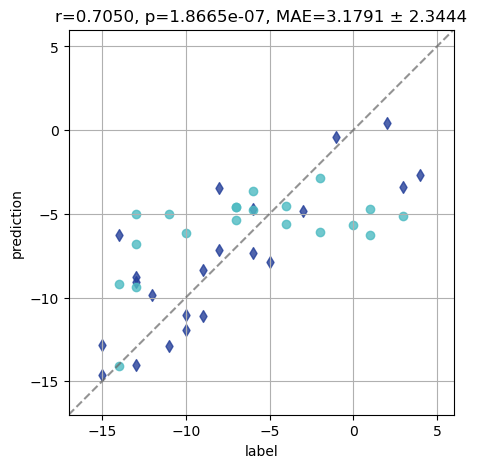

In [82]:
# Plot model fit (training on A, test on A)
combined_df = pd.concat([results_trainP_testP, 
                         results_trainE_testE])
save_path = None if not save_figs else os.path.join(fig_subdir, 'model_fit_within_condition.svg')
true_vs_pred_scatter(combined_df, save_path=save_path)

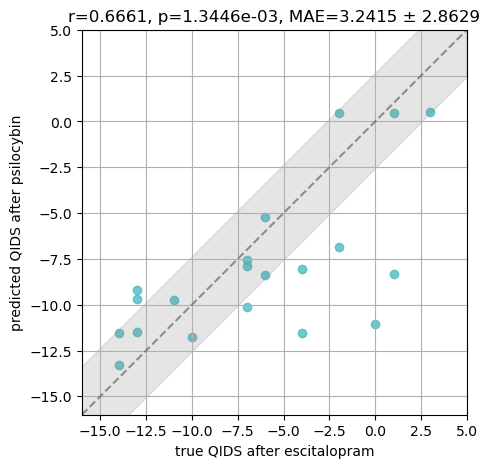

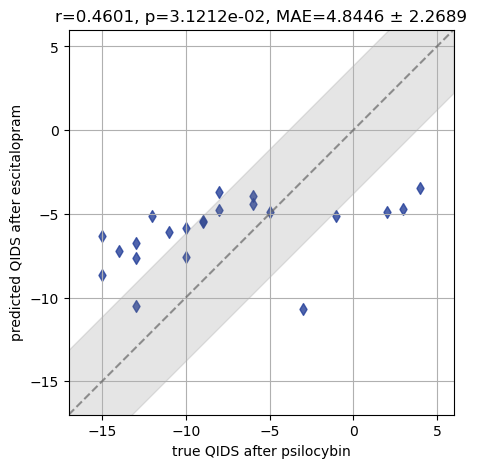

In [83]:
# Plot across-condition results (training on A, evaluating on B)
results_trainP_testE_copy = results_trainP_testE.copy()
results_trainE_testP_copy = results_trainE_testP.copy()
results_trainP_testE_renamed = results_trainP_testE_copy.rename(columns={
    'prediction': 'predicted QIDS after psilocybin',
    'label': 'true QIDS after escitalopram'})
results_trainE_testP_renamed = results_trainE_testP_copy.rename(columns={
    'prediction': 'predicted QIDS after escitalopram',
    'label': 'true QIDS after psilocybin'})

# Plot for model trained on psilocybin, evaluated on escitalopram
save_path = None if not save_figs else os.path.join(fig_subdir, 'true_vs_pred_trainP_testE.svg')
true_vs_pred_scatter_with_patch(results_trainP_testE_renamed, 
                     xcol='true QIDS after escitalopram',
                     ycol='predicted QIDS after psilocybin',
                     patch_radius=mae_within_psilo,
                     save_path=save_path)

# Plot for model trained on escitalopram, evaluated on psilocybin
save_path = None if not save_figs else os.path.join(fig_subdir, 'true_vs_pred_trainE_testP.svg')
true_vs_pred_scatter_with_patch(results_trainE_testP_renamed, 
                     xcol='true QIDS after psilocybin',
                     ycol='predicted QIDS after escitalopram',
                     patch_radius=mae_within_escit,
                     save_path=save_path)

## CV-model agreement (X-graphTRIP)

In [84]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'cv_model_corrs_xgraphTRIP')
os.makedirs(fig_subdir, exist_ok=True)

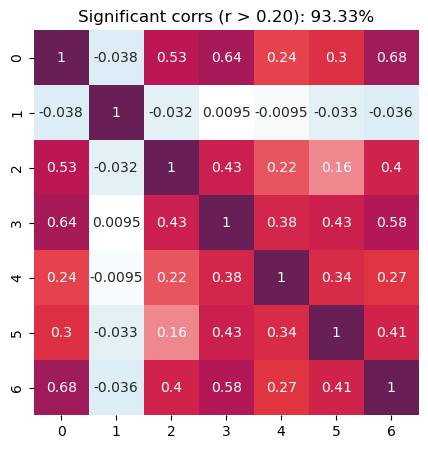

In [85]:
# Load CV-fold model correlations of attention weights (for the main X-graphTRIP model: job 0)
results_dir = os.path.join(output_dir, 'x_graphtrip', 'attention_weights', 'job_0')
mean_corr_matrix = pd.read_csv(os.path.join(results_dir, 'mean_fold_correlations.csv'), header=None)

# Plot mean correlation matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(mean_corr_matrix.values, 
            ax=ax, 
            cmap=COOLWARM, 
            vmin=-1, vmax=1, 
            square=True, 
            annot=True, 
            cbar=False)

# Calculate minimum significant r value
num_features = num_nodes # number of brain regions
r_critical = min_significant_r(num_features)

# Calculate fraction of significant pairs
x_learner_num_folds = len(mean_corr_matrix)
num_unique_pairs = num_folds * (num_folds - 1) / 2
num_significant_pairs = np.sum(np.triu(mean_corr_matrix.values, k=1) > r_critical)
fraction_significant_pairs = (num_significant_pairs / num_unique_pairs)*100
ax.set_title(f'Significant corrs (r > {r_critical:.2f}): {fraction_significant_pairs:.2f}%');

# Save figure
if save_figs:
    save_path = os.path.join(fig_subdir, 'mean_fold_corrs_attention.svg')
    plt.savefig(save_path)

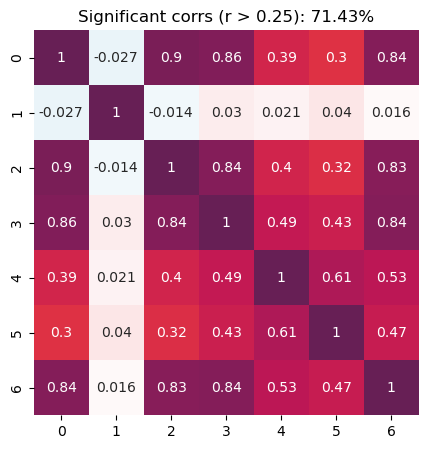

In [86]:
# Load CV-fold model correlations of GRAIL patterns
results_dir = os.path.join(output_dir, 'x_graphtrip', 'grail', 'job_0')
mean_alignments = pd.read_csv(os.path.join(results_dir, 'k0_mean_alignments.csv'))
mean_corr_matrix = pd.read_csv(os.path.join(results_dir, 'mean_fold_correlations.csv'), header=None)

# Plot mean correlation matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(mean_corr_matrix.values, 
            ax=ax, 
            cmap=COOLWARM, 
            vmin=-1, vmax=1, 
            square=True, 
            annot=True, 
            cbar=False)

# Calculate minimum significant r value
num_features = mean_alignments.shape[1]
r_critical = min_significant_r(num_features)

# Calculate fraction of significant pairs
x_learner_num_folds = len(mean_corr_matrix)
num_unique_pairs = x_learner_num_folds * (x_learner_num_folds - 1) / 2
num_significant_pairs = np.sum(np.triu(mean_corr_matrix, k=1) > r_critical)
fraction_significant_pairs = (num_significant_pairs / num_unique_pairs)*100
ax.set_title(f'Significant corrs (r > {r_critical:.2f}): {fraction_significant_pairs:.2f}%');

# Save figure
if save_figs:
    save_path = os.path.join(fig_subdir, 'mean_fold_corrs_grail.svg')
    plt.savefig(save_path)

## Normative molecular target distributions

In [87]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'norm_target_maps')
os.makedirs(fig_subdir, exist_ok=True)

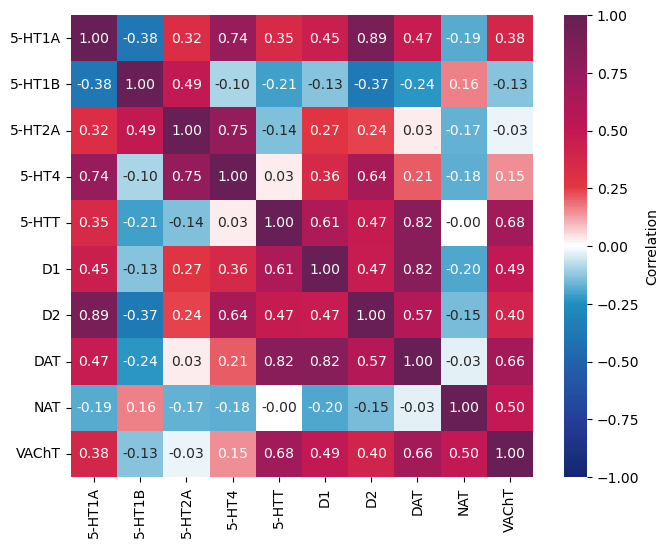

In [88]:
# Load receptor maps
receptors = load_receptor_maps(atlas=data.atlas)

# Plot correlation matrix between receptor distributions
receptor_corr = receptors.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(receptor_corr, 
            cmap=COOLWARM,
            vmin=-1,
            vmax=1,
            square=True,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation'})
if save_figs:
    plt.savefig(os.path.join(fig_subdir, 'receptor_correlations.svg'))